# 📊 Preparación de los datos

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, matthews_corrcoef, f1_score
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Rutas de archivos (Paths)

📂`Se defienen las rutas a los archivos de imágenes, y audios`

In [2]:
gen_path = 'dataset/images/'

# Images paths
stft_mel_full_train_images_path = os.path.join(gen_path, 'stft_mel_full_train_images/')
stft_mfcc_full_train_images_path = os.path.join(gen_path, 'stft_mfcc_full_train_images/')

images_path = os.path.join(gen_path, 'train_images/')
normalized_images_path = os.path.join(gen_path, 'normalized_train_images/')
filtered_images_path = os.path.join(gen_path, 'filtered_train_images/')

stft_mel_1mn_path = os.path.join(gen_path, 'stft_mel_1mn/')
stft_mfcc_1mn_path = os.path.join(gen_path, 'stft_mfcc_1mn/')

stft_mel_3mn_path = os.path.join(gen_path, 'stft_mel_3mn/')
stft_mfcc_3mn_path = os.path.join(gen_path, 'stft_mel_3mn/')

stft_mel_5mn_path = os.path.join(gen_path, 'stft_mel_5mn/')
stft_mfcc_5mn_path = os.path.join(gen_path, 'stft_mfcc_5mn/')

stft_mel_50_path = os.path.join(gen_path, 'stft_mel_50/')
stft_mfcc_50_path = os.path.join(gen_path, 'stft_mfcc_50/')

stft_mel_100_path = os.path.join(gen_path, 'stft_mel_100/')
stft_mfcc_100_path = os.path.join(gen_path, 'stft_mfcc_100/')

stft_mel_500_path = os.path.join(gen_path, 'stft_mel_500/')
stft_mfcc_500_path = os.path.join(gen_path, 'stft_mfcc_500/')

# Audio path
audio_path = os.path.join('dataset/', 'train_audio/')

### Copiar imágenes

📂 `Se copia una porción de las imágenes a los folders de train, test y validación`

🔄 Las imágenes se dividen de la siguiene manera:
- 🏋️ 60% entrenamiento (`train`) 
- 🧪 20% prueba (`test`) 
- ✅ 20% validación (`validation`)

📌 **Nota**: Esto se realiza por cada conjunto de imágenes.
Cada conjunto cuenta con diferentes transformaciones, como **MFCC** y **STFT**.

In [3]:
list_audio = {}

# Class and files
for dir in os.listdir(audio_path):
    dir_path = os.path.join(audio_path, dir)
    if os.path.isdir(dir_path):
        for file in os.listdir(dir_path):
            if dir not in list_audio:
                list_audio[dir] = []
            list_audio[dir].append(file)

In [4]:
def split_data(source_dir, base_output_dir, percentage_test=0.2, percentage_val=0.2):
    
    for split in ['train', 'test', 'val']:
        os.makedirs(os.path.join(base_output_dir, split), exist_ok=True)

    class_folders = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for class_folder in class_folders:
        class_path = os.path.join(source_dir, class_folder)
        files = os.listdir(class_path)
        
        random.shuffle(files)

        num_test = int(len(files) * percentage_test)
        num_val = int(len(files) * percentage_val)

        if num_test <= 0:
            num_test = 1
        
        if num_val <= 0:
            num_val = 1

        test_files = files[:num_test]
        val_files = files[num_test:num_test + num_val]
        train_files = files[num_test + num_val:]

        # Coping files
        for split, split_files in zip(['train','test', 'val'],[train_files, test_files, val_files]):
            split_class_folder = os.path.join(base_output_dir, split, class_folder)
            os.makedirs(split_class_folder, exist_ok=True)
            for file in split_files:
                shutil.copy(os.path.join(class_path, file), split_class_folder)

In [5]:
image_paths = [
    images_path,
    normalized_images_path,
    filtered_images_path,

    stft_mel_1mn_path,
    stft_mel_3mn_path,
    stft_mel_5mn_path,
    stft_mel_50_path,
    stft_mel_100_path,
    stft_mel_500_path,

    stft_mfcc_1mn_path,
    stft_mfcc_3mn_path,
    stft_mfcc_5mn_path,
    stft_mfcc_50_path,
    stft_mfcc_100_path,
    stft_mfcc_500_path,
    
    stft_mel_full_train_images_path,
    stft_mfcc_full_train_images_path
]

with tqdm(total=len(image_paths), dynamic_ncols=True) as pbar:
    for path in image_paths:
        pbar.set_description(f'Processing {path.split("/")[-2]}')
        source_dir = os.path.join(path, path.split('/')[-2] + '/')
        output_dir = path
        split_data(source_dir, output_dir)
        pbar.update(1)

Processing stft_mfcc_full_train_images: 100%|██████████| 16/16 [08:24<00:00, 31.55s/it]


# 📊 Gestión de datos

📂 Se definen las rutas:
- 🏋️ entrenamiento (`train`)
- 🧪 pruebas (`test`)
- ✅ validación (`validation`)

🔎 Procesos adicionales:
- Se obtienen los nombres de las clases de las imágenes.
- Se generan los datasets de entrenamiento, prueba y validación utilizando generadores (`ImageDataGenerator`).

In [9]:
def get_class_names(path):
    class_names = []

    for class_name in os.listdir(path):
        class_names.append(class_name)
    
    return class_names

In [10]:
def generator(data_dir, class_names, image_shape, batch_size=8, class_mode='categorical', subset='validation', shuffle=False):

    datagen = ImageDataGenerator(rescale = 1./255., samplewise_center=True, samplewise_std_normalization=True)

    generator = datagen.flow_from_directory(
        data_dir,
        target_size=image_shape,
        batch_size=batch_size,
        classes=class_names,
        class_mode=class_mode,
        subset='training',
        shuffle=shuffle
    )

    return generator

### Train paths

In [11]:
images_path_train = os.path.join(images_path, 'train/')
normalized_train_path = os.path.join(normalized_images_path, 'train/')
filtered_train_path = os.path.join(filtered_images_path, 'train/')

stft_mfcc_1mn_train_path = os.path.join(stft_mfcc_1mn_path, 'train/')
stft_mel_1mn_train_path = os.path.join(stft_mel_1mn_path, 'train/')

stft_mfcc_3mn_train_path = os.path.join(stft_mfcc_3mn_path, 'train/')
stft_mel_3mn_train_path = os.path.join(stft_mel_3mn_path, 'train/')

stft_mfcc_5mn_train_path = os.path.join(stft_mfcc_5mn_path, 'train/')
stft_mel_5mn_train_path = os.path.join(stft_mel_5mn_path, 'train/')

stft_mfcc_50_train_path = os.path.join(stft_mfcc_50_path, 'train/')
stft_mel_50_train_path = os.path.join(stft_mel_50_path, 'train/')

stft_mfcc_100_train_path = os.path.join(stft_mfcc_100_path, 'train/')
stft_mel_100_train_path = os.path.join(stft_mel_100_path, 'train/')

stft_mfcc_500_train_path = os.path.join(stft_mfcc_500_path, 'train/')
stft_mel_500_train_path = os.path.join(stft_mel_500_path, 'train/')

stft_mel_full_train_path = os.path.join(stft_mel_full_train_images_path,'train/')
stft_mfcc_full_train_path = os.path.join(stft_mfcc_full_train_images_path,'train/')

### Test paths

In [12]:
images_path_test = os.path.join(images_path, 'test/')
normalized_test_path = os.path.join(normalized_images_path, 'test/')
filtered_test_path = os.path.join(filtered_images_path, 'test/')

stft_mfcc_1mn_test_path = os.path.join(stft_mfcc_1mn_path, 'test/')
stft_mel_1mn_test_path = os.path.join(stft_mel_1mn_path, 'test/')

stft_mfcc_3mn_test_path = os.path.join(stft_mfcc_3mn_path, 'test/')
stft_mel_3mn_test_path = os.path.join(stft_mel_3mn_path, 'test/')

stft_mfcc_5mn_test_path = os.path.join(stft_mfcc_5mn_path, 'test/')
stft_mel_5mn_test_path = os.path.join(stft_mel_5mn_path, 'test/')

stft_mfcc_50_test_path = os.path.join(stft_mfcc_50_path, 'test/')
stft_mel_50_test_path = os.path.join(stft_mel_50_path, 'test/')

stft_mfcc_100_test_path = os.path.join(stft_mfcc_100_path, 'test/')
stft_mel_100_test_path = os.path.join(stft_mel_100_path, 'test/')

stft_mfcc_500_test_path = os.path.join(stft_mfcc_500_path, 'test/')
stft_mel_500_test_path = os.path.join(stft_mel_500_path, 'test/')

stft_mel_full_test_path = os.path.join(stft_mel_full_train_images_path,'test/')
stft_mfcc_full_test_path = os.path.join(stft_mfcc_full_train_images_path,'test/')

### Val paths

In [13]:
images_path_val = os.path.join(images_path, 'val/')
normalized_val_path = os.path.join(normalized_images_path, 'val/')
filtered_val_path = os.path.join(filtered_images_path, 'val/')

stft_mfcc_1mn_val_path = os.path.join(stft_mfcc_1mn_path, 'val/')
stft_mel_1mn_val_path = os.path.join(stft_mel_1mn_path, 'val/')

stft_mfcc_3mn_val_path = os.path.join(stft_mfcc_3mn_path, 'val/')
stft_mel_3mn_val_path = os.path.join(stft_mel_3mn_path, 'val/')

stft_mfcc_5mn_val_path = os.path.join(stft_mfcc_5mn_path, 'val/')
stft_mel_5mn_val_path = os.path.join(stft_mel_5mn_path, 'val/')

stft_mfcc_50_val_path = os.path.join(stft_mfcc_50_path, 'val/')
stft_mel_50_val_path = os.path.join(stft_mel_50_path, 'val/')

stft_mfcc_100_val_path = os.path.join(stft_mfcc_100_path, 'val/')
stft_mel_100_val_path = os.path.join(stft_mel_100_path, 'val/')

stft_mfcc_500_val_path = os.path.join(stft_mfcc_500_path, 'val/')
stft_mel_500_val_path = os.path.join(stft_mel_500_path, 'val/')

stft_mel_full_val_path = os.path.join(stft_mel_full_train_images_path,'val/')
stft_mfcc_full_val_path = os.path.join(stft_mfcc_full_train_images_path,'val/')

### Get class names

In [14]:
class_names_images = get_class_names(images_path_train)
class_names_normalized = get_class_names(normalized_train_path)
class_names_filtered = get_class_names(filtered_train_path)

class_names_mfcc_1mn = get_class_names(stft_mfcc_1mn_train_path)
class_names_mel_1mn = get_class_names(stft_mel_1mn_train_path)

class_names_mfcc_3mn = get_class_names(stft_mfcc_3mn_train_path)
class_names_mel_3mn = get_class_names(stft_mel_3mn_train_path)

class_names_mfcc_5mn = get_class_names(stft_mfcc_5mn_train_path)
class_names_mel_5mn = get_class_names(stft_mel_5mn_train_path)

class_names_mfcc_50 = get_class_names(stft_mfcc_50_train_path)
class_names_mel_50 = get_class_names(stft_mel_50_train_path)

class_names_mfcc_100 = get_class_names(stft_mfcc_100_train_path)
class_names_mel_100 = get_class_names(stft_mel_100_train_path)

class_names_mfcc_500 = get_class_names(stft_mfcc_500_train_path)
class_names_mel_500 = get_class_names(stft_mel_500_train_path)

class_names_stft_mel_full = get_class_names(stft_mel_full_train_path)
class_names_stft_mfcc_full = get_class_names(stft_mfcc_full_train_path)

### Train Generators

In [15]:
img_shape = (71,71)

train_img = generator(data_dir=images_path_train,image_shape=img_shape, class_names=class_names_images, batch_size=128, shuffle=True)
train_normlized = generator(data_dir=normalized_train_path,image_shape=img_shape, class_names=class_names_normalized, batch_size=128, shuffle=True)
train_filtered = generator(data_dir=filtered_train_path,image_shape=img_shape, class_names=class_names_filtered, batch_size=128, shuffle=True)

train_stft_mfcc_1mn = generator(data_dir=stft_mfcc_1mn_train_path, image_shape=img_shape, class_names=class_names_mfcc_1mn, batch_size=128, shuffle=True)
train_stft_mel_1mn = generator(data_dir=stft_mel_1mn_train_path, image_shape=img_shape, class_names=class_names_mel_1mn, batch_size=128, shuffle=True)

train_stft_mfcc_3mn = generator(data_dir=stft_mfcc_3mn_train_path, image_shape=img_shape, class_names=class_names_mfcc_3mn, batch_size=128, shuffle=True)
train_stft_mel_3mn = generator(data_dir=stft_mel_3mn_train_path, image_shape=img_shape, class_names=class_names_mel_3mn, batch_size=128, shuffle=True)

train_stft_mfcc_5mn = generator(data_dir=stft_mfcc_5mn_train_path, image_shape=img_shape, class_names=class_names_mfcc_5mn, batch_size=128, shuffle=True)
train_stft_mel_5mn = generator(data_dir=stft_mel_5mn_train_path, image_shape=img_shape, class_names=class_names_mel_5mn, batch_size=128, shuffle=True)

train_stft_mfcc_50 = generator(data_dir=stft_mfcc_50_train_path, image_shape=img_shape, class_names=class_names_mfcc_50, batch_size=128, shuffle=True)
train_stft_mel_50 = generator(data_dir=stft_mel_50_train_path, image_shape=img_shape, class_names=class_names_mel_50, batch_size=128, shuffle=True)

train_stft_mfcc_100 = generator(data_dir=stft_mfcc_100_train_path, image_shape=img_shape, class_names=class_names_mfcc_100, batch_size=128, shuffle=True)
train_stft_mel_100 = generator(data_dir=stft_mel_100_train_path, image_shape=img_shape, class_names=class_names_mel_100, batch_size=128, shuffle=True)

train_stft_mfcc_500 = generator(data_dir=stft_mfcc_500_train_path, image_shape=img_shape, class_names=class_names_mfcc_500, batch_size=128, shuffle=True)
train_stft_mel_500 = generator(data_dir=stft_mel_500_train_path, image_shape=img_shape, class_names=class_names_mel_500, batch_size=128, shuffle=True)

train_stft_mel_full = generator(data_dir=stft_mel_full_train_path,image_shape=img_shape, class_names=class_names_stft_mel_full, batch_size=128, shuffle=True)
train_stft_mfcc_full = generator(data_dir=stft_mfcc_full_train_path,image_shape=img_shape, class_names=class_names_stft_mfcc_full, batch_size=128, shuffle=True)

Found 17248 images belonging to 182 classes.
Found 14789 images belonging to 182 classes.
Found 14789 images belonging to 182 classes.
Found 1878 images belonging to 34 classes.
Found 1878 images belonging to 34 classes.
Found 1514 images belonging to 26 classes.
Found 1514 images belonging to 26 classes.
Found 58 images belonging to 5 classes.
Found 58 images belonging to 5 classes.
Found 1152 images belonging to 27 classes.
Found 1152 images belonging to 27 classes.
Found 5085 images belonging to 49 classes.
Found 5085 images belonging to 49 classes.
Found 7277 images belonging to 25 classes.
Found 7277 images belonging to 25 classes.
Found 14789 images belonging to 182 classes.
Found 14789 images belonging to 182 classes.


### Test Generators

In [16]:
test_img = generator(data_dir=images_path_test,image_shape=(71,71), class_names=class_names_images, batch_size=128, shuffle=False)
test_normlized = generator(data_dir=normalized_test_path,image_shape=img_shape, class_names=class_names_normalized, batch_size=128, shuffle=False)
test_filtered = generator(data_dir=filtered_test_path,image_shape=img_shape, class_names=class_names_filtered, batch_size=128, shuffle=False)

test_stft_mfcc_1mn = generator(data_dir=stft_mfcc_1mn_test_path, image_shape=img_shape, class_names=class_names_mfcc_1mn, batch_size=128, shuffle=False)
test_stft_mel_1mn = generator(data_dir=stft_mel_1mn_test_path, image_shape=img_shape, class_names=class_names_mel_1mn, batch_size=128, shuffle=False)

test_stft_mfcc_3mn = generator(data_dir=stft_mfcc_3mn_test_path, image_shape=img_shape, class_names=class_names_mfcc_3mn, batch_size=128, shuffle=False)
test_stft_mel_3mn = generator(data_dir=stft_mel_3mn_test_path, image_shape=img_shape, class_names=class_names_mel_3mn, batch_size=128, shuffle=False)

test_stft_mfcc_5mn = generator(data_dir=stft_mfcc_5mn_test_path, image_shape=img_shape, class_names=class_names_mfcc_5mn, batch_size=128, shuffle=False)
test_stft_mel_5mn = generator(data_dir=stft_mel_5mn_test_path, image_shape=img_shape, class_names=class_names_mel_5mn, batch_size=128, shuffle=False)

test_stft_mfcc_50 = generator(data_dir=stft_mfcc_50_test_path, image_shape=img_shape, class_names=class_names_mfcc_50, batch_size=128, shuffle=False)
test_stft_mel_50 = generator(data_dir=stft_mel_50_test_path, image_shape=img_shape, class_names=class_names_mel_50, batch_size=128, shuffle=False)

test_stft_mfcc_100 = generator(data_dir=stft_mfcc_100_test_path, image_shape=img_shape, class_names=class_names_mfcc_100, batch_size=128, shuffle=False)
test_stft_mel_100 = generator(data_dir=stft_mel_100_test_path, image_shape=img_shape, class_names=class_names_mel_100, batch_size=128, shuffle=False)

test_stft_mfcc_500 = generator(data_dir=stft_mfcc_500_test_path, image_shape=img_shape, class_names=class_names_mfcc_500, batch_size=128, shuffle=False)
test_stft_mel_500 = generator(data_dir=stft_mel_500_test_path, image_shape=img_shape, class_names=class_names_mel_500, batch_size=128, shuffle=False)

test_stft_mel_full = generator(data_dir=stft_mel_full_test_path,image_shape=img_shape, class_names=class_names_stft_mel_full, batch_size=128, shuffle=False)
test_stft_mfcc_full = generator(data_dir=stft_mfcc_full_test_path,image_shape=img_shape, class_names=class_names_stft_mfcc_full, batch_size=128, shuffle=False)

Found 4835 images belonging to 182 classes.
Found 4835 images belonging to 182 classes.
Found 4835 images belonging to 182 classes.
Found 604 images belonging to 34 classes.
Found 604 images belonging to 34 classes.
Found 631 images belonging to 26 classes.
Found 631 images belonging to 26 classes.
Found 17 images belonging to 5 classes.
Found 17 images belonging to 5 classes.
Found 368 images belonging to 27 classes.
Found 368 images belonging to 27 classes.
Found 1664 images belonging to 49 classes.
Found 1664 images belonging to 49 classes.
Found 2425 images belonging to 25 classes.
Found 2425 images belonging to 25 classes.
Found 4835 images belonging to 182 classes.
Found 4835 images belonging to 182 classes.


### Val Generators

In [17]:
val_img = generator(data_dir=images_path_val,image_shape=(71,71), class_names=class_names_images, batch_size=128, shuffle=True)
val_normlized = generator(data_dir=normalized_val_path,image_shape=img_shape, class_names=class_names_normalized, batch_size=128, shuffle=True)
val_filtered = generator(data_dir=filtered_val_path,image_shape=img_shape, class_names=class_names_filtered, batch_size=128, shuffle=True)

val_stft_mfcc_1mn = generator(data_dir=stft_mfcc_1mn_val_path, image_shape=img_shape, class_names=class_names_mfcc_1mn, batch_size=128, shuffle=True)
val_stft_mel_1mn = generator(data_dir=stft_mel_1mn_val_path, image_shape=img_shape, class_names=class_names_mel_1mn, batch_size=128, shuffle=True)

val_stft_mfcc_3mn = generator(data_dir=stft_mfcc_3mn_val_path, image_shape=img_shape, class_names=class_names_mfcc_3mn, batch_size=128, shuffle=True)
val_stft_mel_3mn = generator(data_dir=stft_mel_3mn_val_path, image_shape=img_shape, class_names=class_names_mel_3mn, batch_size=128, shuffle=True)

val_stft_mfcc_5mn = generator(data_dir=stft_mfcc_5mn_val_path, image_shape=img_shape, class_names=class_names_mfcc_5mn, batch_size=128, shuffle=True)
val_stft_mel_5mn = generator(data_dir=stft_mel_5mn_val_path, image_shape=img_shape, class_names=class_names_mel_5mn, batch_size=128, shuffle=True)

val_stft_mfcc_50 = generator(data_dir=stft_mfcc_50_val_path, image_shape=img_shape, class_names=class_names_mfcc_50, batch_size=128, shuffle=True)
val_stft_mel_50 = generator(data_dir=stft_mel_50_val_path, image_shape=img_shape, class_names=class_names_mel_50, batch_size=128, shuffle=True)

val_stft_mfcc_100 = generator(data_dir=stft_mfcc_100_val_path, image_shape=img_shape, class_names=class_names_mfcc_100, batch_size=128, shuffle=True)
val_stft_mel_100 = generator(data_dir=stft_mel_100_val_path, image_shape=img_shape, class_names=class_names_mel_100, batch_size=128, shuffle=True)

val_stft_mfcc_500 = generator(data_dir=stft_mfcc_500_val_path, image_shape=img_shape, class_names=class_names_mfcc_500, batch_size=128, shuffle=True)
val_stft_mel_500 = generator(data_dir=stft_mel_500_val_path, image_shape=img_shape, class_names=class_names_mel_500, batch_size=128, shuffle=True)

val_stft_mel_full = generator(data_dir=stft_mel_full_val_path,image_shape=img_shape, class_names=class_names_stft_mel_full, batch_size=128, shuffle=True)
val_stft_mfcc_full = generator(data_dir=stft_mfcc_full_val_path,image_shape=img_shape, class_names=class_names_stft_mfcc_full, batch_size=128, shuffle=True)

Found 2376 images belonging to 182 classes.
Found 4835 images belonging to 182 classes.
Found 4835 images belonging to 182 classes.
Found 604 images belonging to 34 classes.
Found 604 images belonging to 34 classes.
Found 634 images belonging to 26 classes.
Found 634 images belonging to 26 classes.
Found 17 images belonging to 5 classes.
Found 17 images belonging to 5 classes.
Found 368 images belonging to 27 classes.
Found 368 images belonging to 27 classes.
Found 1664 images belonging to 49 classes.
Found 1664 images belonging to 49 classes.
Found 2425 images belonging to 25 classes.
Found 2425 images belonging to 25 classes.
Found 4835 images belonging to 182 classes.
Found 4835 images belonging to 182 classes.


# 🧠 Convolutional Neural Network (CNN)

🚀 **Se crean los modelos CNN** para la clasificación de imágenes:
- 🟢 **DenseNet121**
- 🟡 **Xception**
- 🔵 **VGG19**

In [12]:
def get_model(base_model, hidden_layers, activation, output, output_activation, dropout=None, freeze_base_model=True):
    # freeze layers
    for lys in base_model.layers:
                lys.trainable = not freeze_base_model
    mdl = base_model.output

    for hl in hidden_layers:
        mdl = tf.keras.layers.Dense(hl, activation=activation)(mdl)
    if dropout:
        mdl = tf.keras.layers.Dropout(dropout)(mdl)
    mdl = tf.keras.layers.Dense(output, activation=output_activation)(mdl)
    model = tf.keras.models.Model(base_model.input, mdl)
    return model

### 🟢 DenseNet

In [13]:
def densenet(path, learning_rate, epochs , output, validation ,shape, hidden_layers=[512], activation='relu', output_activation='softmax'):
    
    model_densenet = tf.keras.applications.DenseNet121(input_shape=shape, include_top=False, weights='imagenet', pooling='max')
    model_densenet = get_model(model_densenet, hidden_layers, activation, output, output_activation, freeze_base_model=False)
    
    model_densenet.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6, min_delta=1e-3)

    history = model_densenet.fit(path, epochs=epochs, validation_data=validation, callbacks=[early_stopping,reduce_lr])

    return model_densenet, history

### 🟡 Xception

In [14]:
def xception(path, learning_rate, epochs , output, validation ,shape, hidden_layers=[512], activation='relu', output_activation='softmax'):
    
    model_xception = tf.keras.applications.Xception(input_shape=shape, include_top=False, weights='imagenet', pooling='max')
    model_xception = get_model(model_xception, hidden_layers, activation, output, output_activation, freeze_base_model=False)
    
    model_xception.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6, min_delta=1e-3)

    history = model_xception.fit(path, epochs=epochs, validation_data=validation, callbacks=[early_stopping,reduce_lr])

    return model_xception, history

### 🔵 VGG19

In [15]:
def vgg19(path, learning_rate, epochs , output, validation ,shape, hidden_layers=[512], activation='relu', output_activation='softmax'):
    
    model_VGG19 = tf.keras.applications.VGG19(input_shape=shape, include_top=False, weights='imagenet', pooling='max')
    model_VGG19 = get_model(model_VGG19, hidden_layers, activation, output, output_activation, freeze_base_model=False)
    
    model_VGG19.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6, min_delta=1e-3)

    history = model_VGG19.fit(path, epochs=epochs, validation_data=validation, callbacks=[early_stopping,reduce_lr])

    return model_VGG19, history

## ⚙️ Train

⚙️ **Se entrenan los modelos** con los diferentes conjuntos de imágenes

📷 **Conjuntos de imágenes**

- 🎶 Simple MFCC Images
- ➗ Normalized Images
- 🔲 Filtered Imagess
- 🕜 STFT Mel and MFCC **1 minute Images**
- 🕒 STFT Mel and MFCC **3 minute Images**
- 🕠 STFT Mel and MFCC **5 minute Images**
- 🪫 STFT Mel and MFCC: **Groups with 50 &le; Images &le; 99**
- 🔋 STFT Mel and MFCC: **Groups with 100 &le; Images < 300**
- 🔋 STFT Mel and MFCC: **Groups with 300 &le; Images &le; 500**
- 🌏 MFCC and Mel: **All Classes**

In [16]:
def train(path, learning_rate, epochs , output, validation ,shape=(32,32, 3), hidden_layers=[512], activation='relu', output_activation='softmax'):
    densenet_model, history_densenet = densenet(path=path, learning_rate=learning_rate, epochs=epochs, output=output,
                                                    validation=validation,shape=shape,
                                                    hidden_layers=hidden_layers, activation=activation, output_activation=output_activation)

    xception_model, history_xception = xception(path=path, learning_rate=learning_rate, epochs=epochs, output=output,
                                                    validation=validation,shape=shape,
                                                    hidden_layers=hidden_layers, activation=activation, output_activation=output_activation)

    vgg19_model, history_vgg19 = vgg19(path=path, learning_rate=learning_rate, epochs=epochs, output=output,
                                                    validation=validation,shape=shape,
                                                    hidden_layers=hidden_layers, activation=activation, output_activation=output_activation)
    
    return [densenet_model, history_densenet], [xception_model, history_xception], [vgg19_model, history_vgg19]

In [17]:
def save_results(model_1, model_path_1, history_path_1, 
                model_2, model_path_2, history_path_2,
                model_3, model_path_3, history_path_3,):
    model_a = model_1[0]
    model_b = model_2[0]
    model_c = model_3[0]
    
    model_a.save(model_path_1)
    pd.DataFrame(model_1[1].history).to_csv(history_path_1, index=False)

    model_b.save(model_path_2)
    pd.DataFrame(model_2[1].history).to_csv(history_path_2, index=False)

    model_c.save(model_path_3)
    pd.DataFrame(model_3[1].history).to_csv(history_path_3, index=False)

In [18]:
def plot_multiple_histories(histories, titles=None):
    num_histories = len(histories)
    fig, axes = plt.subplots(1, num_histories, figsize=(6 * num_histories, 5), sharey=True)
    
    if num_histories == 1:
        axes = [axes]
    
    for i, history in enumerate(histories):
        hist = {
            'Loss': history.history['loss'],
            'Validation Loss': history.history['val_loss']
        }
        sns.lineplot(data=hist, palette='viridis', ax=axes[i])
        
        axes[i].set_title(titles[i] if titles and len(titles) > i else f'Model {i+1}')
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel('Loss' if i == 0 else '')
        axes[i].legend(hist.keys(), loc='upper right')
    
    plt.tight_layout()
    plt.show()

### 🎶 Simple MFCC Images

In [19]:
simple_mfcc_densenet, simple_mfcc_xception, simple_mfcc_vgg19 = train(path=train_img, learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=val_img,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
135/135 [==============================] - 141s 962ms/step - loss: 4.1011 - accuracy: 0.1304 - mse: 0.0052 - val_loss: 5.5273 - val_accuracy: 0.0804 - val_mse: 0.0061 - lr: 0.0010
Epoch 2/50
135/135 [==============================] - 67s 499ms/step - loss: 3.2012 - accuracy: 0.2588 - mse: 0.0047 - val_loss: 3.7068 - val_accuracy: 0.2176 - val_mse: 0.0053 - lr: 0.0010
Epoch 3/50
135/135 [==============================] - 68s 500ms/step - loss: 2.7980 - accuracy: 0.3279 - mse: 0.0044 - val_loss: 3.7211 - val_accuracy: 0.2374 - val_mse: 0.0052 - lr: 0.0010
Epoch 4/50
135/135 [==============================] - 67s 497ms/step - loss: 2.5042 - accuracy: 0.3860 - mse: 0.0041 - val_loss: 3.5700 - val_accuracy: 0.2424 - val_mse: 0.0051 - lr: 0.0010
Epoch 5/50
135/135 [==============================] - 69s 511ms/step - loss: 2.2303 - accuracy: 0.4384 - mse: 0.0038 - val_loss: 3.1759 - val_accuracy: 0.3039 - val_mse: 0.0048 - lr: 0.0010
Epoch 6/50
135/135 [=============================

In [20]:
save_results(simple_mfcc_densenet, './models/simple_mfcc_densenet.h5', './hist/hist_simple_mfcc_densenet.csv',
            simple_mfcc_xception, './models/simple_mfcc_xception.h5', './hist/hist_simple_mfcc_xception.csv',
            simple_mfcc_vgg19, './models/simple_mfcc_vgg19.h5', './hist/hist_simple_mfcc_vgg19.csv')

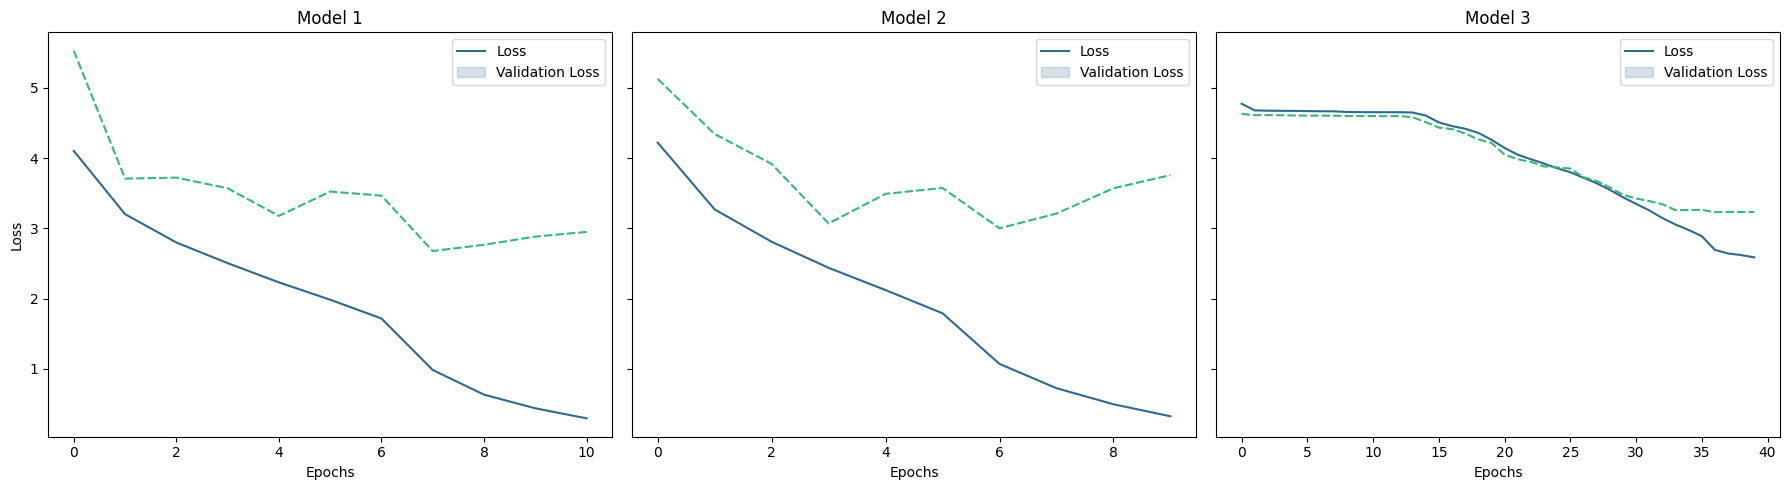

In [21]:
plot_multiple_histories([simple_mfcc_densenet[1], simple_mfcc_xception[1], simple_mfcc_vgg19[1]])

### ➗ Normalized Images

In [ ]:
normalized_densenet, normalized_xception, normalized_vgg19 = train(path=train_normlized, learning_rate=0.001, epochs=50, output=len(class_names_normalized),
                                                                        validation=val_normlized,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
116/116 [==============================] - 76s 604ms/step - loss: 4.2093 - accuracy: 0.1185 - mse: 0.0053 - val_loss: 5.2994 - val_accuracy: 0.0763 - val_mse: 0.0062 - lr: 0.0010
Epoch 2/50
116/116 [==============================] - 13s 107ms/step - loss: 3.4283 - accuracy: 0.2317 - mse: 0.0049 - val_loss: 4.3421 - val_accuracy: 0.1363 - val_mse: 0.0056 - lr: 0.0010
Epoch 3/50
116/116 [==============================] - 13s 108ms/step - loss: 3.0799 - accuracy: 0.2894 - mse: 0.0046 - val_loss: 3.7823 - val_accuracy: 0.1975 - val_mse: 0.0052 - lr: 0.0010
Epoch 4/50
116/116 [==============================] - 13s 109ms/step - loss: 2.8106 - accuracy: 0.3373 - mse: 0.0044 - val_loss: 4.2587 - val_accuracy: 0.1491 - val_mse: 0.0056 - lr: 0.0010
Epoch 5/50
116/116 [==============================] - ETA: 0s - loss: 2.5791 - accuracy: 0.3836 - mse: 0.0041
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
116/116 [==============================] - 12s 107ms/

In [23]:
save_results(normalized_densenet, './models/normalized_densenet.h5', './hist/hist_normalized_densenet.csv',
            normalized_xception, './models/normalized_xception.h5', './hist/hist_normalized_xception.csv',
            normalized_vgg19, './models/normalized_vgg19.h5', './hist/hist_normalized_vgg19.csv')

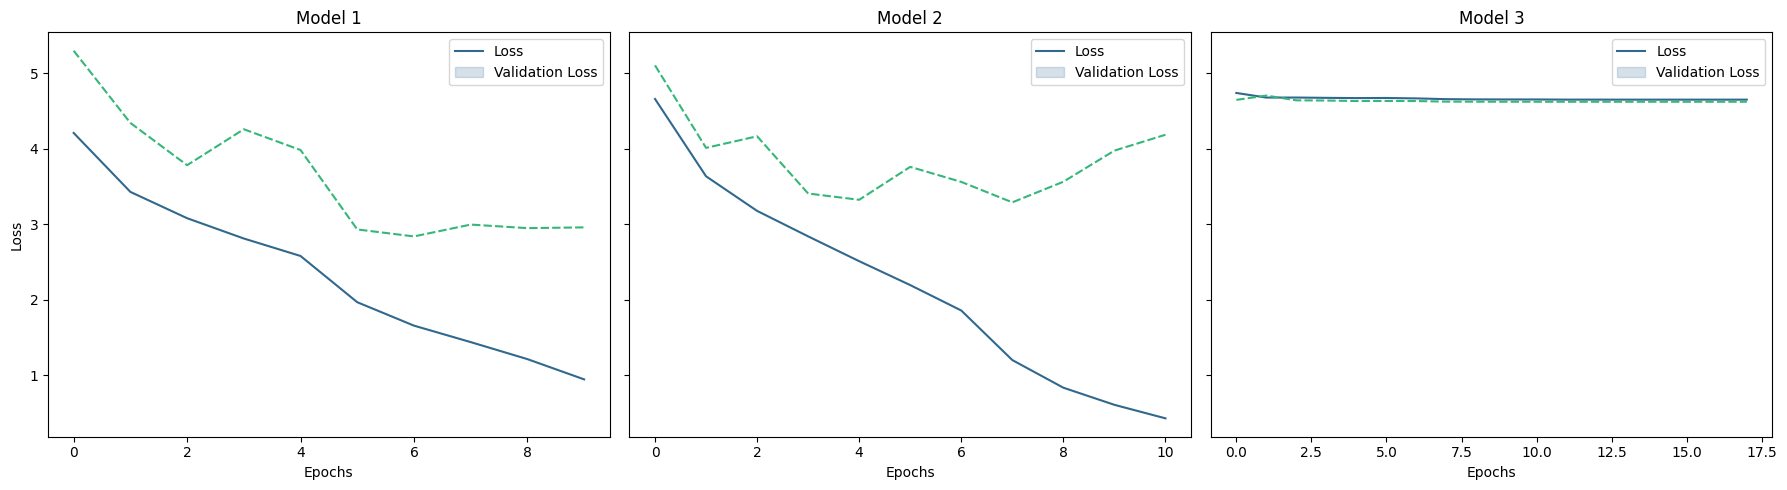

In [24]:
plot_multiple_histories([normalized_densenet[1], normalized_xception[1], normalized_vgg19[1]])

### 🔲 Filtered Images

In [25]:
filtered_densenet, filtered_xception, filtered_vgg19 = train(path=train_filtered, learning_rate=0.001, epochs=50, output=len(class_names_filtered),
                                                                        validation=val_filtered,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
116/116 [==============================] - 76s 600ms/step - loss: 4.4239 - accuracy: 0.0863 - mse: 0.0053 - val_loss: 5.3987 - val_accuracy: 0.0600 - val_mse: 0.0066 - lr: 0.0010
Epoch 2/50
116/116 [==============================] - 13s 107ms/step - loss: 3.7537 - accuracy: 0.1751 - mse: 0.0051 - val_loss: 4.2502 - val_accuracy: 0.1233 - val_mse: 0.0053 - lr: 0.0010
Epoch 3/50
116/116 [==============================] - 13s 110ms/step - loss: 3.4515 - accuracy: 0.2209 - mse: 0.0049 - val_loss: 20.4552 - val_accuracy: 0.0867 - val_mse: 0.0064 - lr: 0.0010
Epoch 4/50
116/116 [==============================] - 13s 107ms/step - loss: 3.1983 - accuracy: 0.2649 - mse: 0.0047 - val_loss: 3.7685 - val_accuracy: 0.1975 - val_mse: 0.0051 - lr: 0.0010
Epoch 5/50
116/116 [==============================] - 12s 106ms/step - loss: 2.9855 - accuracy: 0.2988 - mse: 0.0046 - val_loss: 3.5617 - val_accuracy: 0.2132 - val_mse: 0.0050 - lr: 0.0010
Epoch 6/50
116/116 [=============================

In [26]:
save_results(filtered_densenet, './models/filtered_densenet.h5', './hist/hist_filtered_densenet.csv',
            filtered_xception, './models/filtered_xception.h5', './hist/hist_filtered_xception.csv',
            filtered_vgg19, './models/filtered_vgg19.h5', './hist/hist_filtered_vgg19.csv')

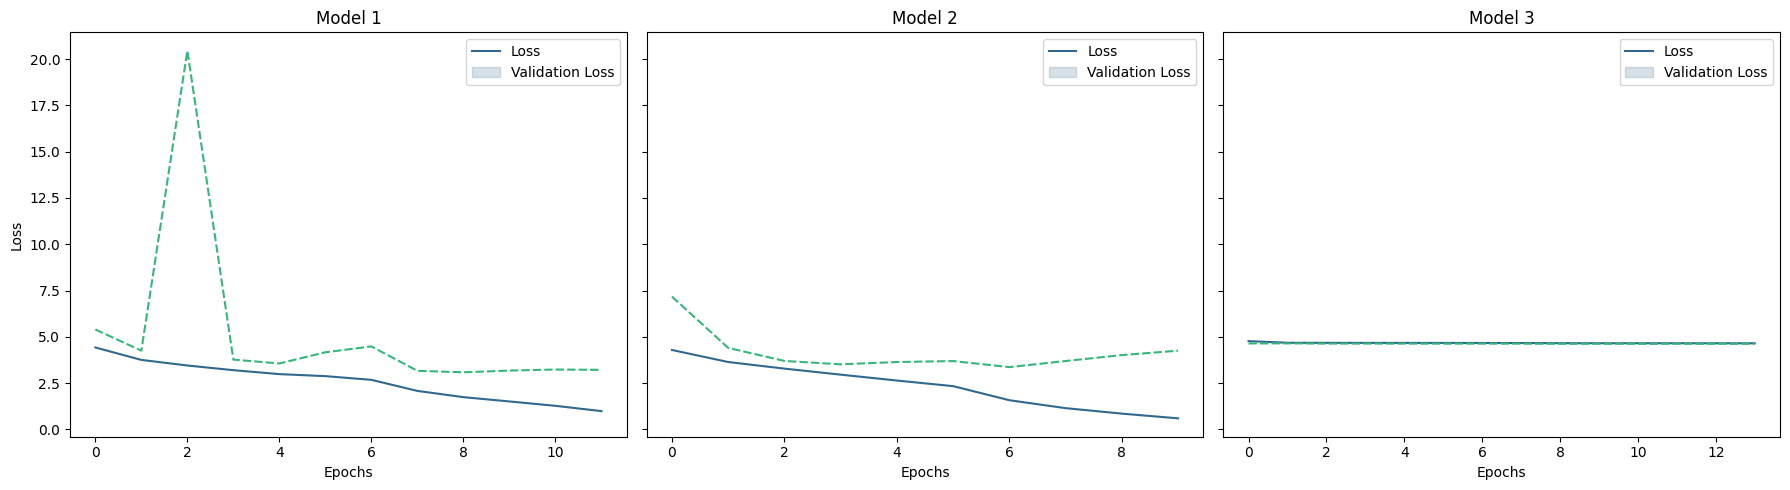

In [27]:
plot_multiple_histories([filtered_densenet[1], filtered_xception[1], filtered_vgg19[1]])

### 🕜 STFT Mel and MFCC 1 minute Images

In [28]:
stft_mfcc_1mn_densenet, stft_mfcc_1mn_xception, stft_mfcc_1mn_vgg19 = train(path=train_stft_mfcc_1mn , learning_rate=0.001, epochs=50, output=len(class_names_mfcc_1mn),
                                                                                    validation=val_stft_mfcc_1mn ,shape=(img_shape[0], img_shape[1], 3),
                                                                                    hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
15/15 [==============================] - 21s 960ms/step - loss: 3.8942 - accuracy: 0.0602 - mse: 0.0295 - val_loss: 10.4408 - val_accuracy: 0.0315 - val_mse: 0.0394 - lr: 0.0010
Epoch 2/50
15/15 [==============================] - 5s 351ms/step - loss: 3.4329 - accuracy: 0.1177 - mse: 0.0281 - val_loss: 79.2797 - val_accuracy: 0.0331 - val_mse: 0.0449 - lr: 0.0010
Epoch 3/50
15/15 [==============================] - ETA: 0s - loss: 3.2316 - accuracy: 0.1443 - mse: 0.0276
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
15/15 [==============================] - 5s 332ms/step - loss: 3.2316 - accuracy: 0.1443 - mse: 0.0276 - val_loss: 37.6315 - val_accuracy: 0.0348 - val_mse: 0.0417 - lr: 0.0010
Epoch 4/50
15/15 [==============================] - 5s 359ms/step - loss: 2.8779 - accuracy: 0.2306 - mse: 0.0261 - val_loss: 14.0542 - val_accuracy: 0.0596 - val_mse: 0.0364 - lr: 1.0000e-04
Epoch 4: early stopping
Epoch 1/50
15/15 [===========================

In [29]:
stft_mel_1mn_densenet, stft_mel_1mn_xception, stft_mel_1mn_vgg19 = train(path=train_stft_mel_1mn , learning_rate=0.001, epochs=50, output=len(class_names_mel_1mn),
                                                                        validation=val_stft_mel_1mn,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
15/15 [==============================] - 21s 967ms/step - loss: 3.8692 - accuracy: 0.0884 - mse: 0.0295 - val_loss: 19.8085 - val_accuracy: 0.0381 - val_mse: 0.0533 - lr: 0.0010
Epoch 2/50
15/15 [==============================] - 6s 363ms/step - loss: 2.8741 - accuracy: 0.2460 - mse: 0.0258 - val_loss: 9.6916 - val_accuracy: 0.0579 - val_mse: 0.0428 - lr: 0.0010
Epoch 3/50
15/15 [==============================] - 6s 379ms/step - loss: 1.9246 - accuracy: 0.4611 - mse: 0.0203 - val_loss: 5.5358 - val_accuracy: 0.0944 - val_mse: 0.0362 - lr: 0.0010
Epoch 4/50
15/15 [==============================] - 6s 393ms/step - loss: 1.1192 - accuracy: 0.6656 - mse: 0.0135 - val_loss: 4.2292 - val_accuracy: 0.1838 - val_mse: 0.0303 - lr: 0.0010
Epoch 5/50
15/15 [==============================] - 6s 380ms/step - loss: 0.5630 - accuracy: 0.8403 - mse: 0.0073 - val_loss: 3.5155 - val_accuracy: 0.2136 - val_mse: 0.0288 - lr: 0.0010
Epoch 6/50
15/15 [==============================] - 6s 367ms/st

In [30]:
save_results(stft_mfcc_1mn_densenet, './models/stft_mfcc_1mn_densenet.h5', './hist/hist_stft_mfcc_1mn_densenet.csv',
            stft_mfcc_1mn_xception, './models/stft_mfcc_1mn_xception.h5', './hist/hist_stft_mfcc_1mn_xception.csv',
            stft_mfcc_1mn_vgg19, './models/stft_mfcc_1mn_vgg19.h5', './hist/hist_stft_mfcc_1mn_vgg19.csv')

save_results(stft_mel_1mn_densenet, './models/stft_mel_1mn_densenet.h5', './hist/hist_stft_mel_1mn_densenet.csv',
            stft_mel_1mn_xception, './models/stft_mel_1mn_xception.h5', './hist/hist_stft_mel_1mn_xception.csv',
            stft_mel_1mn_vgg19, './models/stft_mel_1mn_vgg19.h5', './hist/hist_stft_mel_1mn_vgg19.csv')

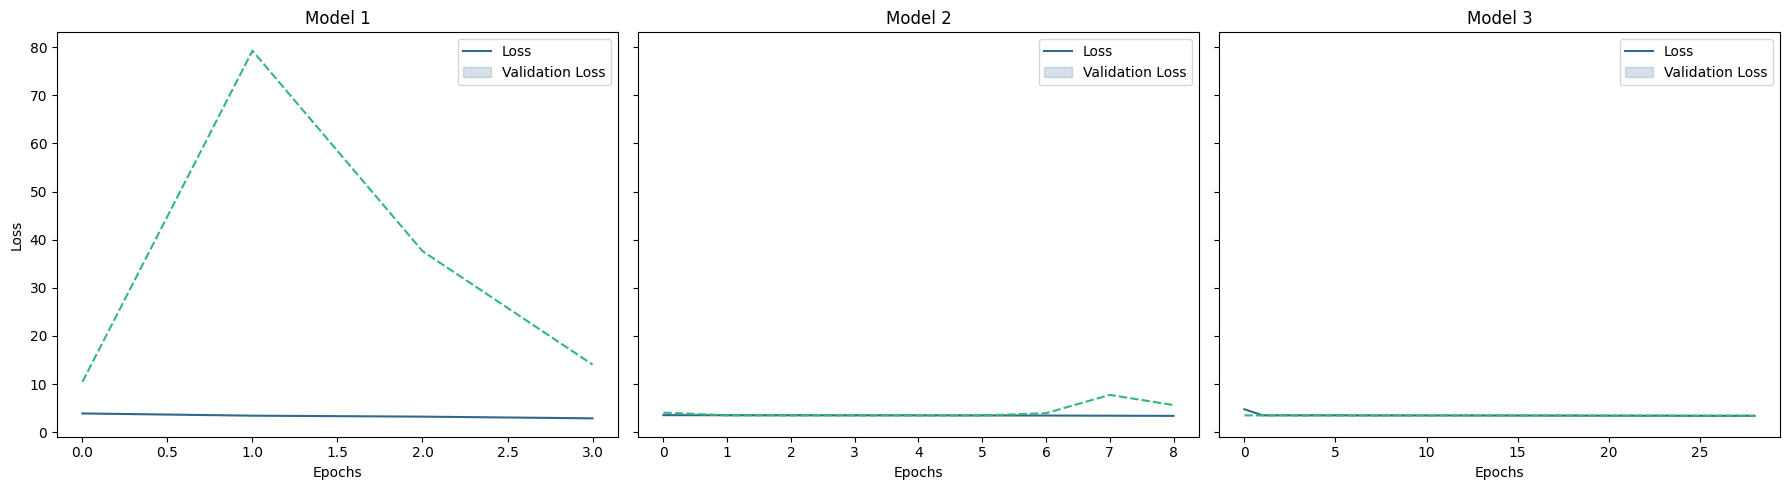

In [31]:
plot_multiple_histories([stft_mfcc_1mn_densenet[1], stft_mfcc_1mn_xception[1], stft_mfcc_1mn_vgg19[1]])

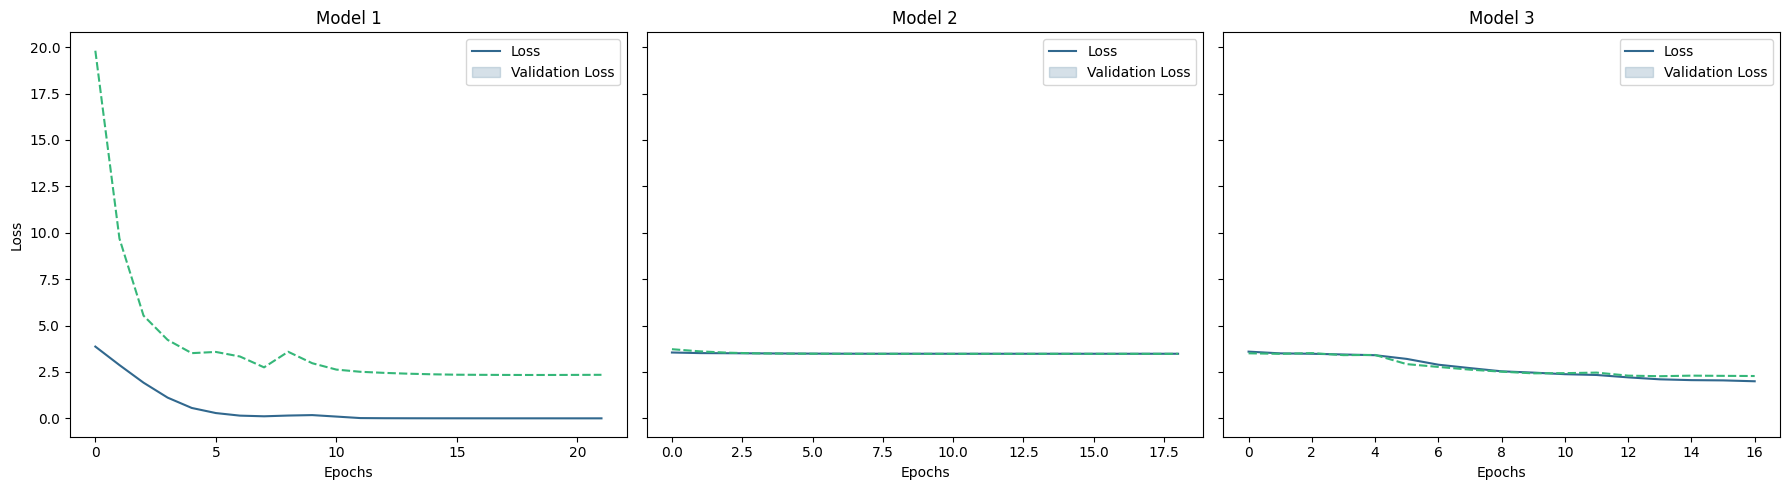

In [32]:
plot_multiple_histories([stft_mel_1mn_densenet[1], stft_mel_1mn_xception[1], stft_mel_1mn_vgg19[1]])

### 🕒 STFT Mel and MFCC 3 minute Images

In [33]:
stft_mel_3mn_densenet, stft_mel_3mn_xception, stft_mel_3mn_vgg19 = train(path=train_stft_mel_3mn, learning_rate=0.001, epochs=50, output=len(class_names_mel_3mn),
                                                                        validation=val_stft_mel_3mn,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
12/12 [==============================] - 19s 1s/step - loss: 3.3591 - accuracy: 0.1506 - mse: 0.0373 - val_loss: 10.6228 - val_accuracy: 0.0931 - val_mse: 0.0567 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 5s 438ms/step - loss: 2.1703 - accuracy: 0.3897 - mse: 0.0288 - val_loss: 7.1232 - val_accuracy: 0.0615 - val_mse: 0.0506 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 5s 431ms/step - loss: 1.2640 - accuracy: 0.6334 - mse: 0.0190 - val_loss: 6.7379 - val_accuracy: 0.1278 - val_mse: 0.0463 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 5s 430ms/step - loss: 0.6579 - accuracy: 0.8137 - mse: 0.0105 - val_loss: 4.6752 - val_accuracy: 0.1435 - val_mse: 0.0448 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 5s 425ms/step - loss: 0.3272 - accuracy: 0.9009 - mse: 0.0054 - val_loss: 3.5873 - val_accuracy: 0.2555 - val_mse: 0.0368 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 5s 428ms/step 

In [34]:
stft_mfcc_3mn_densenet, stft_mfcc_3mn_xception, stft_mfcc_3mn_vgg19 = train(path=train_stft_mfcc_3mn , learning_rate=0.001, epochs=50, output=len(class_names_mfcc_3mn),
                                                                        validation=val_stft_mfcc_3mn,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
12/12 [==============================] - 12s 529ms/step - loss: 3.4476 - accuracy: 0.1453 - mse: 0.0375 - val_loss: 203.4425 - val_accuracy: 0.1073 - val_mse: 0.0687 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 5s 401ms/step - loss: 2.5936 - accuracy: 0.3151 - mse: 0.0317 - val_loss: 55.7205 - val_accuracy: 0.0946 - val_mse: 0.0620 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 5s 402ms/step - loss: 1.8488 - accuracy: 0.4775 - mse: 0.0255 - val_loss: 154.0020 - val_accuracy: 0.0615 - val_mse: 0.0693 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 5s 405ms/step - loss: 1.2067 - accuracy: 0.6473 - mse: 0.0188 - val_loss: 24.2314 - val_accuracy: 0.1215 - val_mse: 0.0588 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 5s 404ms/step - loss: 0.6676 - accuracy: 0.7985 - mse: 0.0111 - val_loss: 4.4037 - val_accuracy: 0.2934 - val_mse: 0.0408 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 5s 405

In [35]:
save_results(stft_mel_3mn_densenet, './models/stft_mel_3mn_densenet.h5', './hist/hist_stft_mel_3mn_densenet.csv',
            stft_mel_3mn_xception, './models/stft_mel_3mn_xception.h5', './hist/hist_stft_mel_3mn_xception.csv',
            stft_mel_3mn_vgg19, './models/stft_mel_3mn_vgg19.h5', './hist/hist_stft_mel_3mn_vgg19.csv')

save_results(stft_mfcc_3mn_densenet, './models/stft_mfcc_3mn_densenet.h5', './hist/hist_stft_mfcc_3mn_densenet.csv',
            stft_mfcc_3mn_xception, './models/stft_mfcc_3mn_xception.h5', './hist/hist_stft_mfcc_3mn_xception.csv',
            stft_mfcc_3mn_vgg19, './models/stft_mfcc_3mn_vgg19.h5', './hist/hist_stft_mfcc_3mn_vgg19.csv')

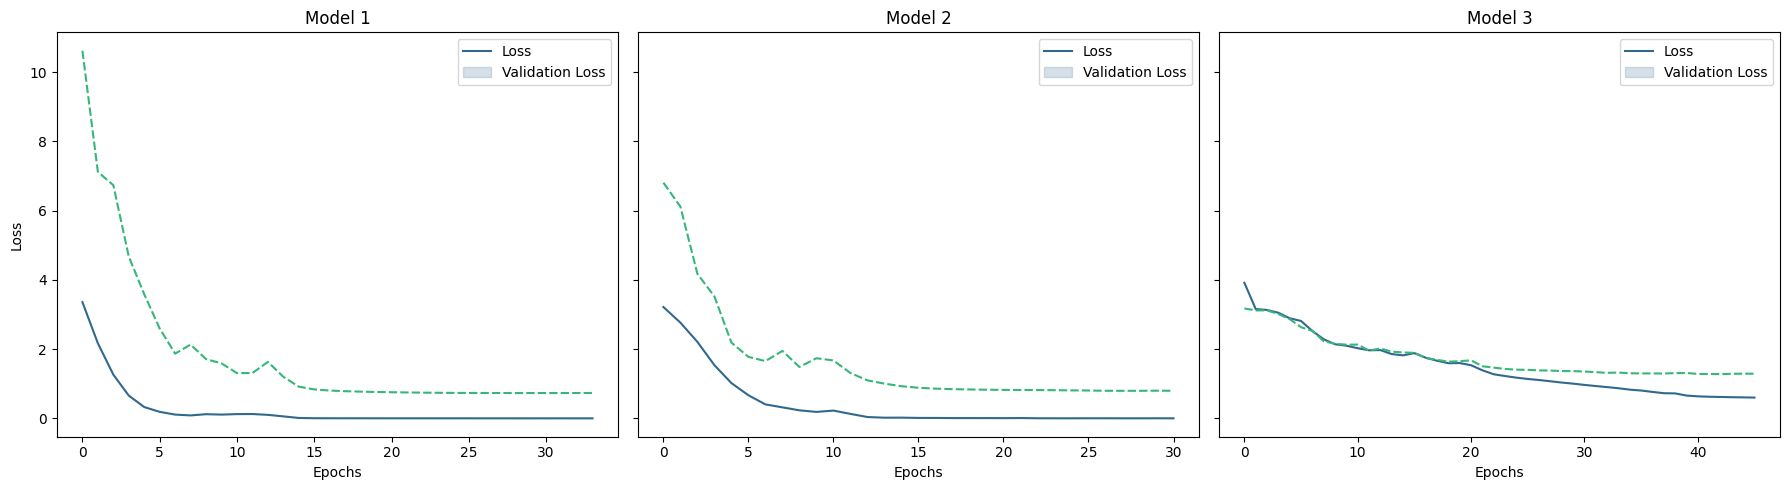

In [36]:
plot_multiple_histories([stft_mel_3mn_densenet[1], stft_mel_3mn_xception[1], stft_mel_3mn_vgg19[1]])

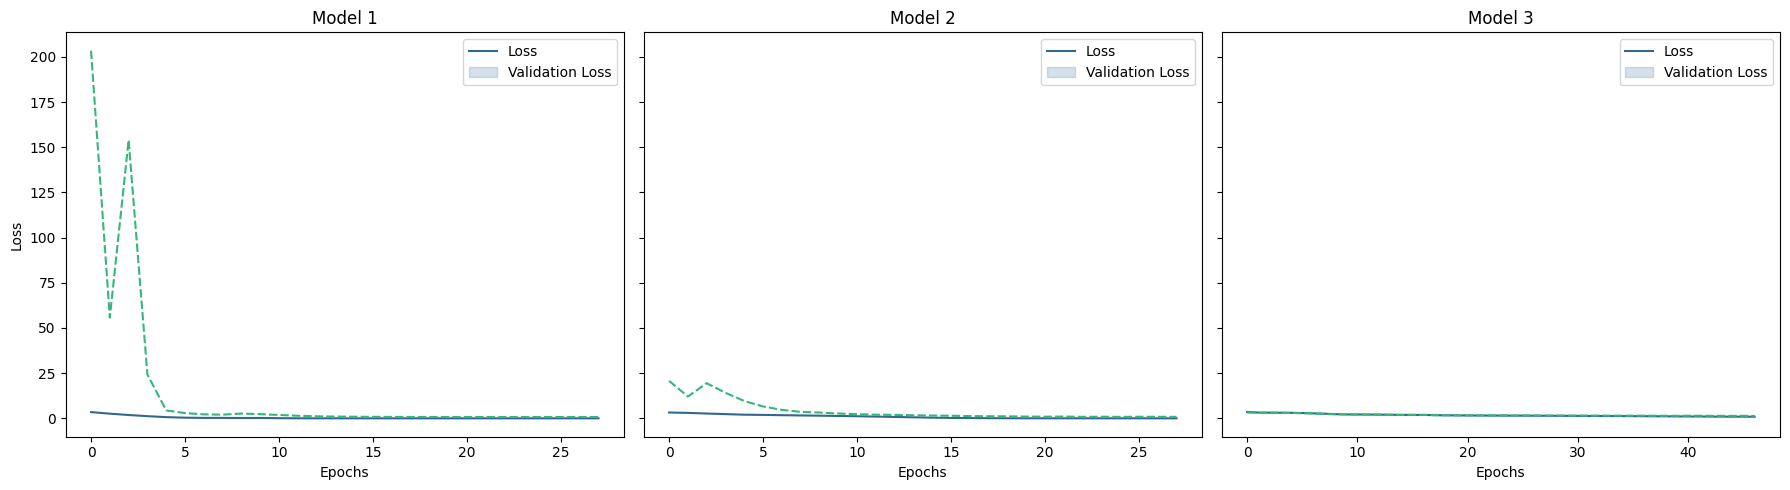

In [37]:
plot_multiple_histories([stft_mfcc_3mn_densenet[1], stft_mfcc_3mn_xception[1], stft_mfcc_3mn_vgg19[1]])

### 🕠 STFT Mel and MFCC 5 minute Images

In [38]:
stft_mel_5mn_densenet, stft_mel_5mn_xception, stft_mel_5mn_vgg19 = train(path=train_stft_mel_5mn, learning_rate=0.001, epochs=50, output=len(class_names_mel_5mn),
                                                                        validation=val_stft_mel_5mn,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
1/1 [==============================] - 8s 8s/step - loss: 2.6449 - accuracy: 0.1379 - mse: 0.2227 - val_loss: 6.4783 - val_accuracy: 0.3529 - val_mse: 0.2551 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 0s 349ms/step - loss: 1.8194 - accuracy: 0.4655 - mse: 0.1606 - val_loss: 5.0447 - val_accuracy: 0.4118 - val_mse: 0.1983 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 0s 289ms/step - loss: 0.4559 - accuracy: 0.8621 - mse: 0.0420 - val_loss: 5.1149 - val_accuracy: 0.4118 - val_mse: 0.1863 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.0850 - accuracy: 1.0000 - mse: 0.0049
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1/1 [==============================] - 0s 287ms/step - loss: 0.0850 - accuracy: 1.0000 - mse: 0.0049 - val_loss: 5.4348 - val_accuracy: 0.4118 - val_mse: 0.1942 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 0s 425ms/step - loss: 0.0246 - accuracy: 

In [39]:
stft_mfcc_5mn_densenet, stft_mfcc_5mn_xception, stft_mfcc_5mn_vgg19 = train(path=train_stft_mfcc_5mn, learning_rate=0.001, epochs=50, output=len(class_names_mfcc_5mn),
                                                                        validation=val_stft_mfcc_5mn,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
1/1 [==============================] - 9s 9s/step - loss: 2.5601 - accuracy: 0.1724 - mse: 0.2122 - val_loss: 4.6233 - val_accuracy: 0.3529 - val_mse: 0.2548 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 1s 515ms/step - loss: 1.8412 - accuracy: 0.4483 - mse: 0.1656 - val_loss: 2.8535 - val_accuracy: 0.2941 - val_mse: 0.1969 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 0s 243ms/step - loss: 0.4319 - accuracy: 0.8966 - mse: 0.0431 - val_loss: 5.2221 - val_accuracy: 0.2353 - val_mse: 0.2952 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.1063 - accuracy: 0.9655 - mse: 0.0092
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1/1 [==============================] - 0s 244ms/step - loss: 0.1063 - accuracy: 0.9655 - mse: 0.0092 - val_loss: 7.9765 - val_accuracy: 0.2353 - val_mse: 0.3024 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 0s 373ms/step - loss: 0.0285 - accuracy: 

In [40]:
save_results(stft_mel_5mn_densenet, './models/stft_mel_5mn_densenet.h5', './hist/hist_stft_mel_5mn_densenet.csv',
            stft_mel_5mn_xception, './models/stft_mel_5mn_xception.h5', './hist/hist_stft_mel_5mn_xception.csv',
            stft_mel_5mn_vgg19, './models/stft_mel_5mn_vgg19.h5', './hist/hist_stft_mel_5mn_vgg19.csv')

save_results(stft_mfcc_5mn_densenet, './models/stft_mfcc_5mn_densenet.h5', './hist/hist_stft_mfcc_5mn_densenet.csv',
            stft_mfcc_5mn_xception, './models/stft_mfcc_5mn_xception.h5', './hist/hist_stft_mfcc_5mn_xception.csv',
            stft_mfcc_5mn_vgg19, './models/stft_mfcc_5mn_vgg19.h5', './hist/hist_stft_mfcc_5mn_vgg19.csv')

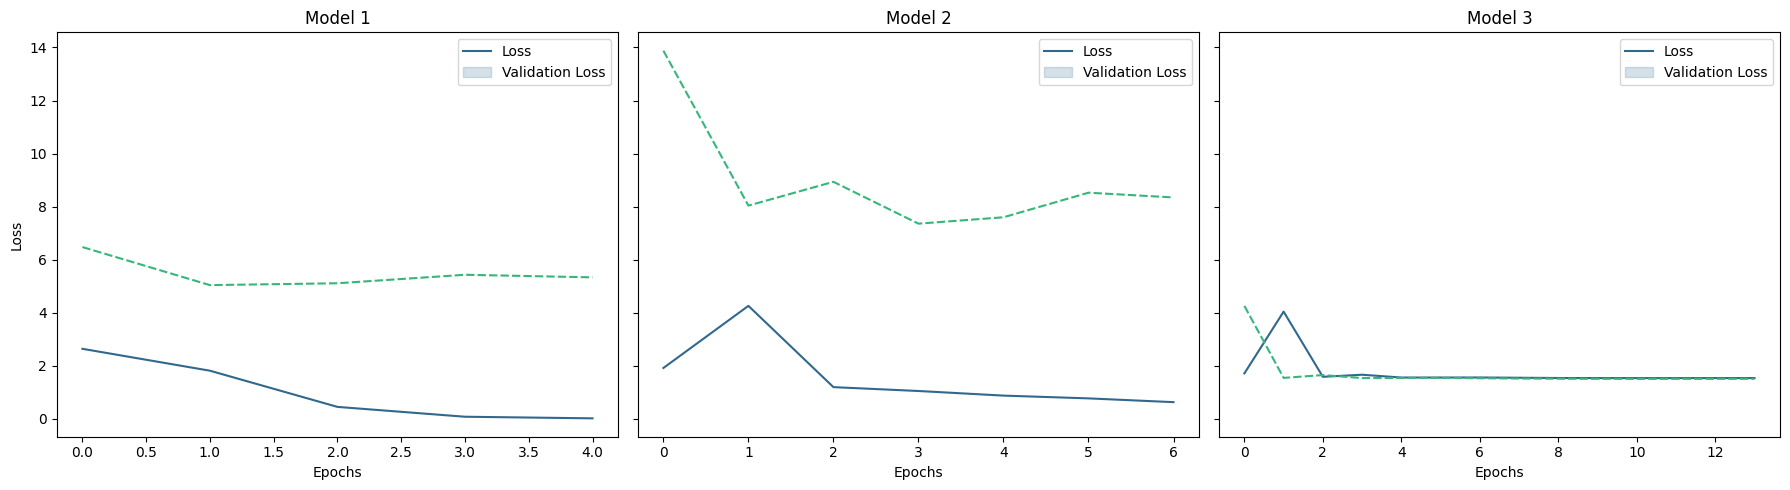

In [41]:
plot_multiple_histories([stft_mel_5mn_densenet[1], stft_mel_5mn_xception[1], stft_mel_5mn_vgg19[1]])

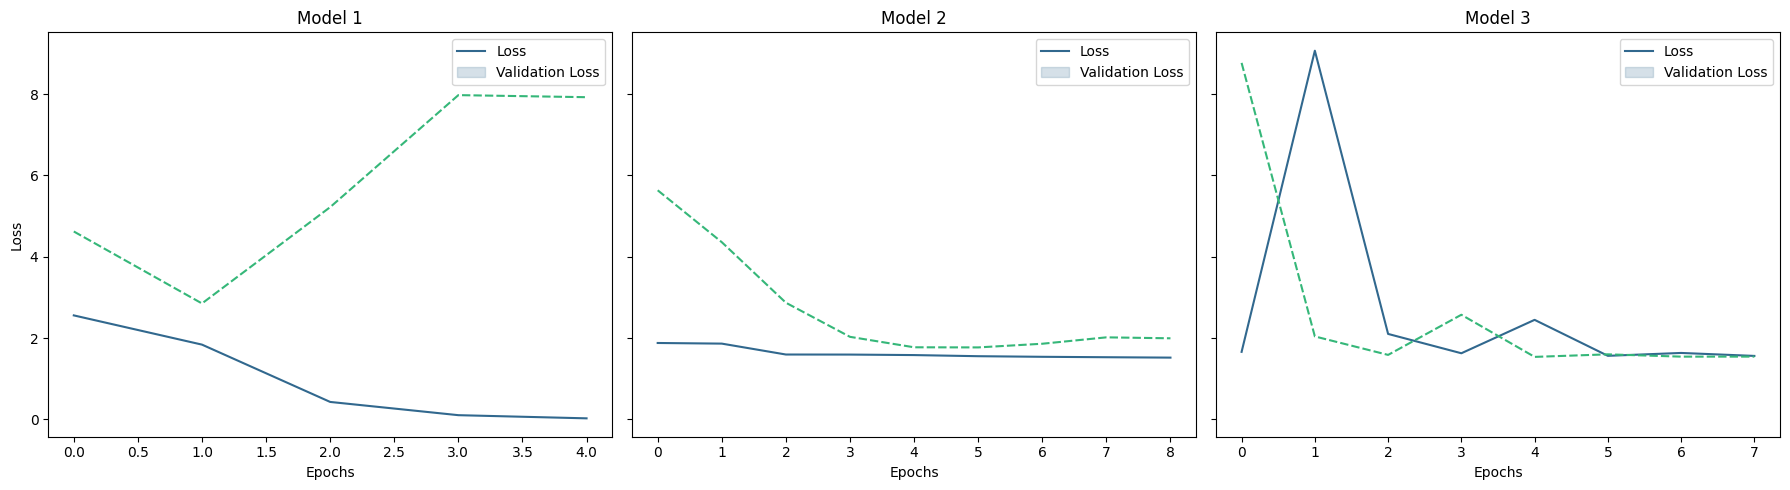

In [42]:
plot_multiple_histories([stft_mfcc_5mn_densenet[1], stft_mfcc_5mn_xception[1], stft_mfcc_5mn_vgg19[1]])

### 🪫 STFT Mel and MFCC: Groups with 50 &le; Images &le; 99

In [43]:
stft_mel_50_densenet, stft_mel_50_xception, stft_mel_50_vgg19 = train(path=train_stft_mel_50, learning_rate=0.001, epochs=50, output=len(class_names_mel_50),
                                                                        validation=val_stft_mel_50,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
9/9 [==============================] - 15s 1s/step - loss: 3.8048 - accuracy: 0.0703 - mse: 0.0374 - val_loss: 13.5835 - val_accuracy: 0.0272 - val_mse: 0.0543 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 3s 371ms/step - loss: 3.0308 - accuracy: 0.1997 - mse: 0.0332 - val_loss: 145.5575 - val_accuracy: 0.0543 - val_mse: 0.0659 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 2.4149 - accuracy: 0.3585 - mse: 0.0292
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
9/9 [==============================] - 3s 371ms/step - loss: 2.4149 - accuracy: 0.3585 - mse: 0.0292 - val_loss: 28.1962 - val_accuracy: 0.0842 - val_mse: 0.0603 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 3s 388ms/step - loss: 1.8206 - accuracy: 0.5078 - mse: 0.0243 - val_loss: 15.8649 - val_accuracy: 0.0815 - val_mse: 0.0582 - lr: 1.0000e-04
Epoch 4: early stopping
Epoch 1/50
9/9 [==============================] - 7s 454m

In [44]:
stft_mfcc_50_densenet, stft_mfcc_50_xception, stft_mfcc_50_vgg19 = train(path=train_stft_mfcc_50, learning_rate=0.001, epochs=50, output=len(class_names_mfcc_50),
                                                                        validation=val_stft_mfcc_50,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
9/9 [==============================] - 15s 979ms/step - loss: 3.8197 - accuracy: 0.0590 - mse: 0.0377 - val_loss: 37.0722 - val_accuracy: 0.0272 - val_mse: 0.0712 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 3s 315ms/step - loss: 3.2658 - accuracy: 0.1424 - mse: 0.0352 - val_loss: 56.5529 - val_accuracy: 0.0408 - val_mse: 0.0704 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 3s 341ms/step - loss: 2.9407 - accuracy: 0.1962 - mse: 0.0341 - val_loss: 7.5302 - val_accuracy: 0.0571 - val_mse: 0.0475 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 3s 332ms/step - loss: 2.3707 - accuracy: 0.3359 - mse: 0.0300 - val_loss: 9.3471 - val_accuracy: 0.0380 - val_mse: 0.0636 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 3s 341ms/step - loss: 1.3963 - accuracy: 0.6285 - mse: 0.0200 - val_loss: 5.6248 - val_accuracy: 0.0435 - val_mse: 0.0460 - lr: 0.0010
Epoch 6/50
9/9 [==============================] - 3s 337ms/step - loss: 

In [45]:
save_results(stft_mel_50_densenet, './models/stft_mel_50_densenet.h5', './hist/hist_stft_mel_50_densenet.csv',
            stft_mel_50_xception, './models/stft_mel_50_xception.h5', './hist/hist_stft_mel_50_xception.csv',
            stft_mel_50_vgg19, './models/stft_mel_50_vgg19.h5', './hist/hist_stft_mel_50_vgg19.csv')

save_results(stft_mfcc_50_densenet, './models/stft_mfcc_50_densenet.h5', './hist/hist_stft_mfcc_50_densenet.csv',
            stft_mfcc_50_xception, './models/stft_mfcc_50_xception.h5', './hist/hist_stft_mfcc_50_xception.csv',
            stft_mfcc_50_vgg19, './models/stft_mfcc_50_vgg19.h5', './hist/hist_stft_mfcc_50_vgg19.csv')

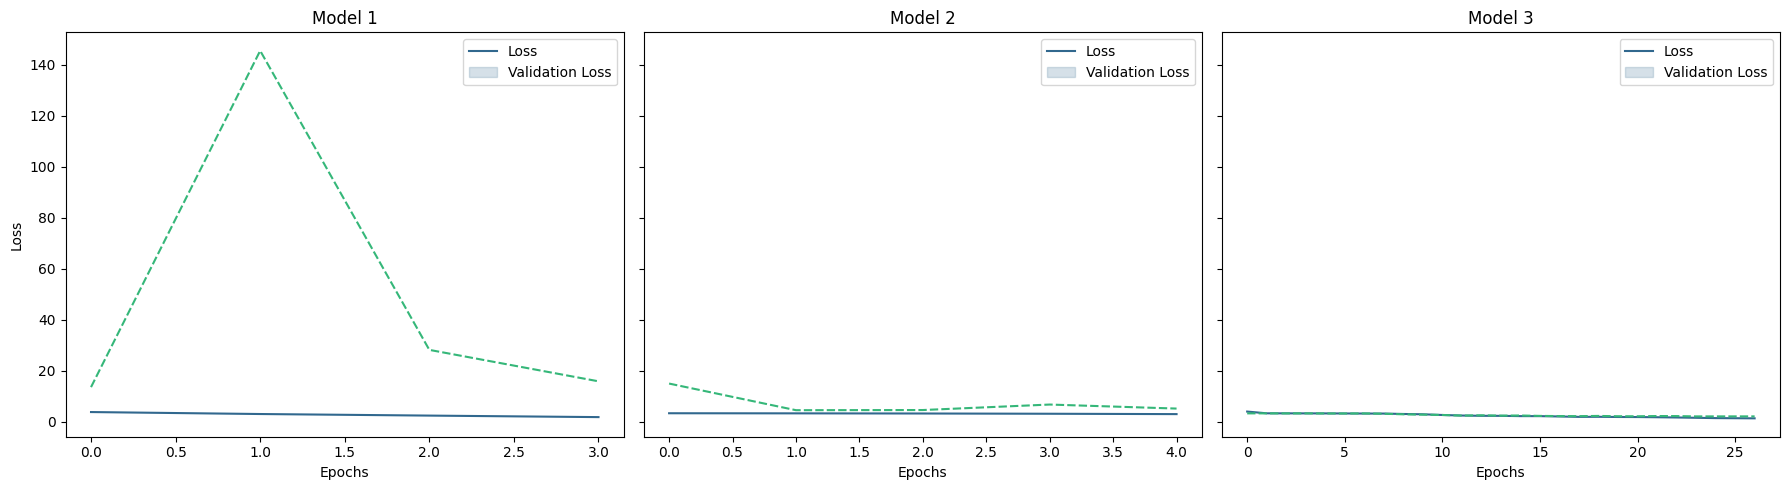

In [46]:
plot_multiple_histories([stft_mel_50_densenet[1], stft_mel_50_xception[1], stft_mel_50_vgg19[1]])

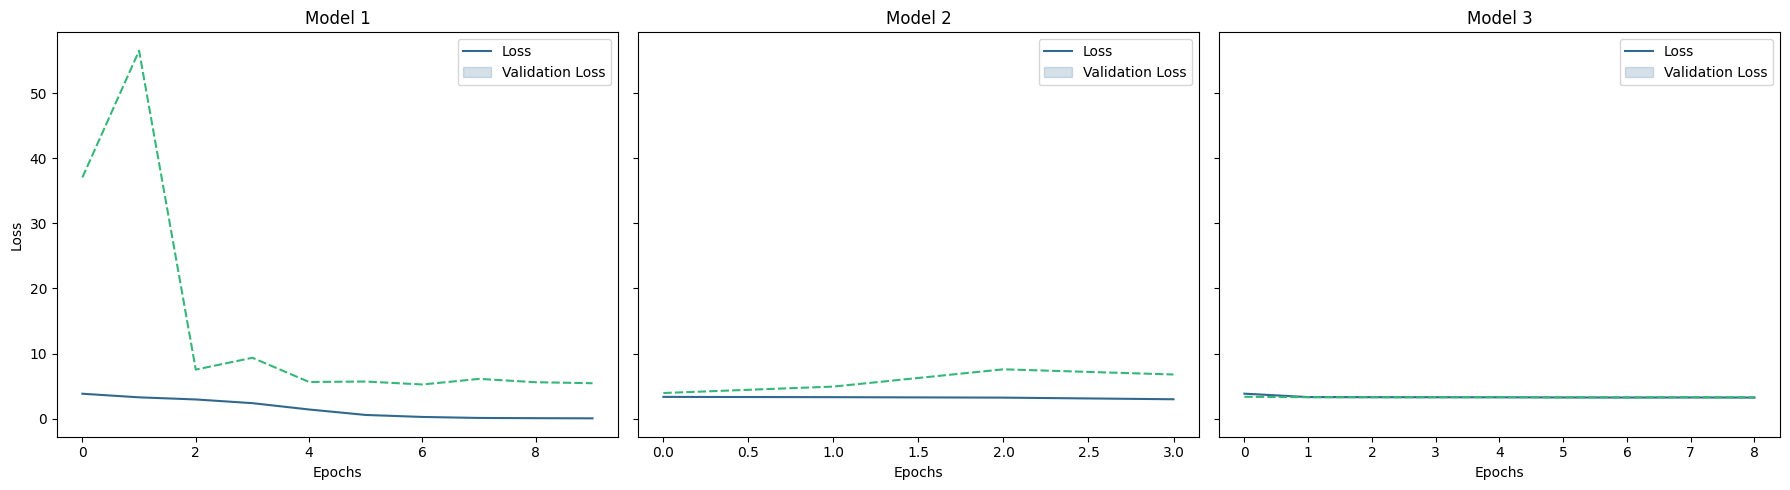

In [47]:
plot_multiple_histories([stft_mfcc_50_densenet[1], stft_mfcc_50_xception[1], stft_mfcc_50_vgg19[1]])

### 🔋 STFT Mel and MFCC: Groups with 100 &le; Images < 300

In [48]:
stft_mel_100_densenet, stft_mel_100_xception, stft_mel_100_vgg19 = train(path=train_stft_mel_100 , learning_rate=0.001, epochs=50, output=len(class_names_mel_100),
                                                                        validation=val_stft_mel_100,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
40/40 [==============================] - 42s 899ms/step - loss: 3.7069 - accuracy: 0.1263 - mse: 0.0195 - val_loss: 5.4687 - val_accuracy: 0.0619 - val_mse: 0.0236 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 15s 364ms/step - loss: 2.5185 - accuracy: 0.3282 - mse: 0.0165 - val_loss: 5.1812 - val_accuracy: 0.1214 - val_mse: 0.0257 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 15s 367ms/step - loss: 1.8613 - accuracy: 0.4710 - mse: 0.0135 - val_loss: 3.0296 - val_accuracy: 0.2224 - val_mse: 0.0188 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 15s 366ms/step - loss: 1.3691 - accuracy: 0.6029 - mse: 0.0107 - val_loss: 2.9199 - val_accuracy: 0.3269 - val_mse: 0.0183 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 15s 364ms/step - loss: 1.0056 - accuracy: 0.7042 - mse: 0.0084 - val_loss: 2.9612 - val_accuracy: 0.3221 - val_mse: 0.0182 - lr: 0.0010
Epoch 6/50
40/40 [==============================] - ETA: 0s 

In [49]:
stft_mfcc_100_densenet, stft_mfcc_100_xception, stft_mfcc_100_vgg19 = train(path=train_stft_mfcc_100, learning_rate=0.001, epochs=50, output=len(class_names_mfcc_100),
                                                                        validation=val_stft_mfcc_100,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
40/40 [==============================] - 41s 873ms/step - loss: 4.1177 - accuracy: 0.0366 - mse: 0.0203 - val_loss: 22.1142 - val_accuracy: 0.0222 - val_mse: 0.0236 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 13s 328ms/step - loss: 3.8041 - accuracy: 0.0529 - mse: 0.0199 - val_loss: 4.7091 - val_accuracy: 0.0559 - val_mse: 0.0213 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 13s 323ms/step - loss: 3.5592 - accuracy: 0.0968 - mse: 0.0196 - val_loss: 4.3718 - val_accuracy: 0.0709 - val_mse: 0.0215 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 13s 325ms/step - loss: 3.3177 - accuracy: 0.1422 - mse: 0.0191 - val_loss: 4.4654 - val_accuracy: 0.0944 - val_mse: 0.0223 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 13s 327ms/step - loss: 3.0155 - accuracy: 0.2033 - mse: 0.0183 - val_loss: 3.9497 - val_accuracy: 0.1196 - val_mse: 0.0208 - lr: 0.0010
Epoch 6/50
40/40 [==============================] - 13s 323

In [50]:
save_results(stft_mel_100_densenet, './models/stft_mel_100_densenet.h5', './hist/hist_stft_mel_100_densenet.csv',
            stft_mel_100_xception, './models/stft_mel_100_xception.h5', './hist/hist_stft_mel_100_xception.csv',
            stft_mel_100_vgg19, './models/stft_mel_100_vgg19.h5', './hist/hist_stft_mel_100_vgg19.csv')

save_results(stft_mfcc_100_densenet, './models/stft_mfcc_100_densenet.h5', './hist/hist_stft_mfcc_100_densenet.csv',
            stft_mfcc_100_xception, './models/stft_mfcc_100_xception.h5', './hist/hist_stft_mfcc_100_xception.csv',
            stft_mfcc_100_vgg19, './models/stft_mfcc_100_vgg19.h5', './hist/hist_stft_mfcc_100_vgg19.csv')

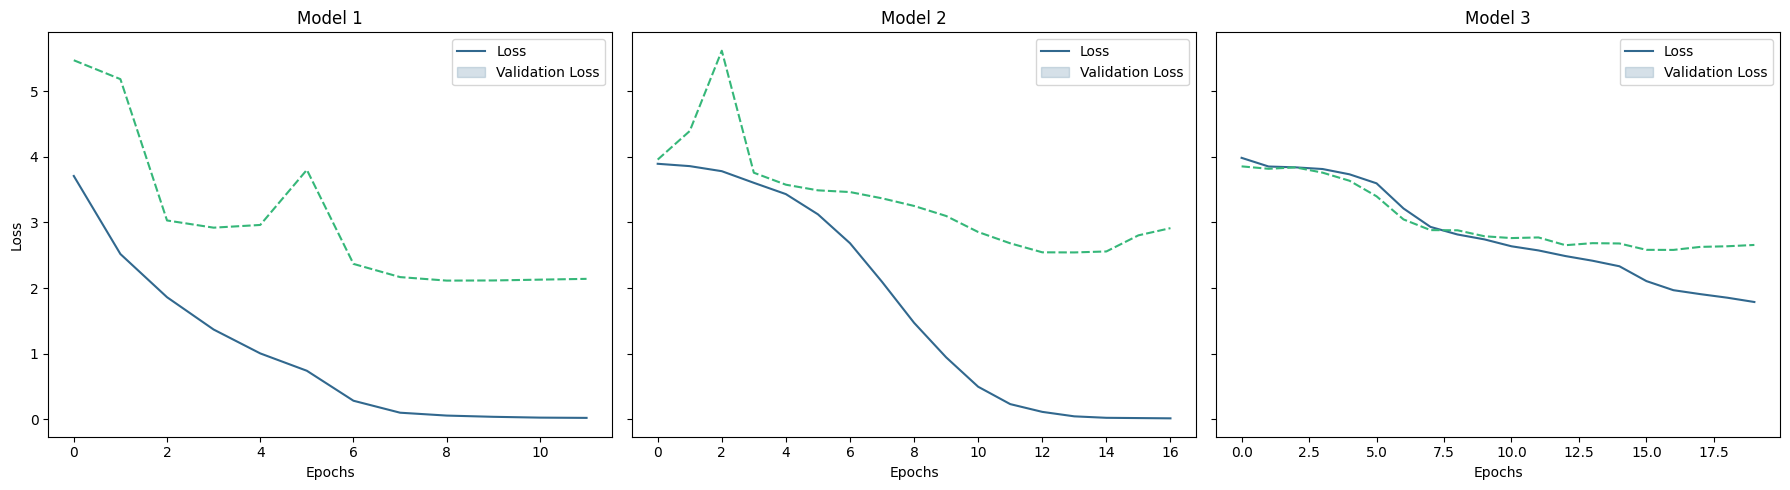

In [51]:
plot_multiple_histories([stft_mel_100_densenet[1], stft_mel_100_xception[1], stft_mel_100_vgg19[1]])

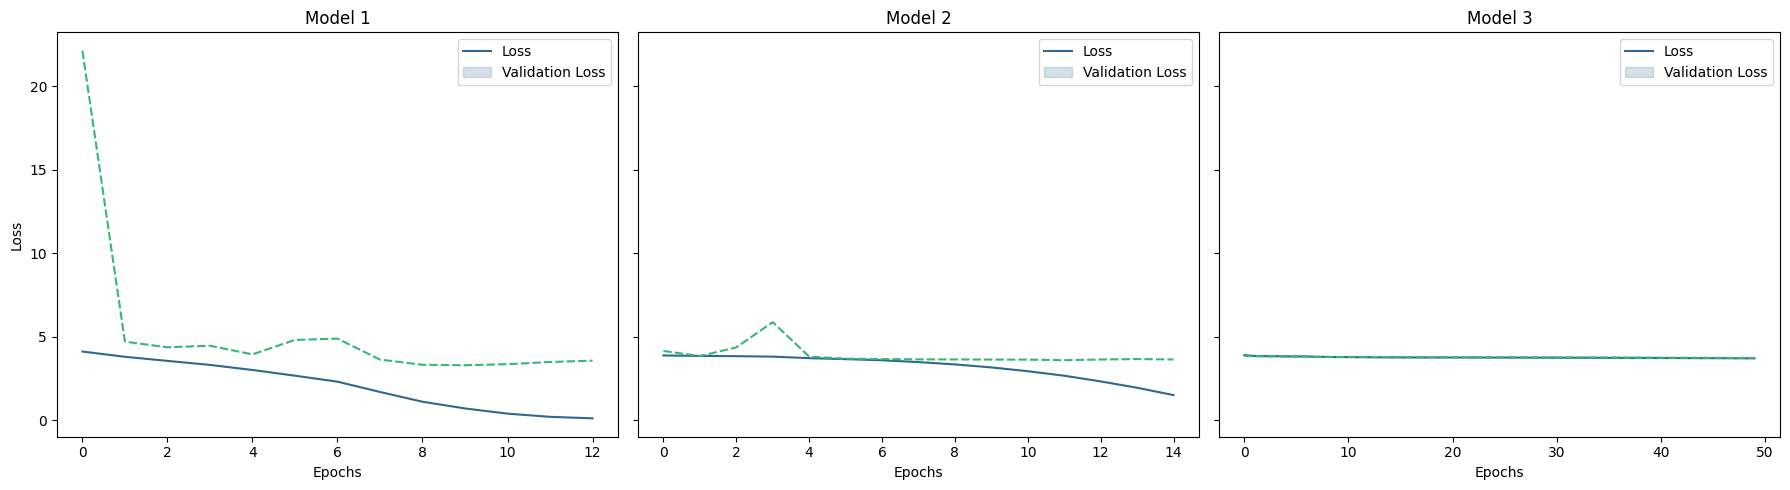

In [52]:
plot_multiple_histories([stft_mfcc_100_densenet[1], stft_mfcc_100_xception[1], stft_mfcc_100_vgg19[1]])

### 🔋 STFT Mel and MFCC: Groups with 300 &le; Images &le; 500

In [53]:
stft_mel_500_densenet, stft_mel_500_xception, stft_mel_500_vgg19 = train(path=train_stft_mel_500, learning_rate=0.001, epochs=50, output=len(class_names_mel_500),
                                                                        validation=val_stft_mel_500,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
57/57 [==============================] - 58s 894ms/step - loss: 2.6849 - accuracy: 0.2614 - mse: 0.0347 - val_loss: 37.5937 - val_accuracy: 0.0540 - val_mse: 0.0734 - lr: 0.0010
Epoch 2/50
57/57 [==============================] - 21s 367ms/step - loss: 1.4630 - accuracy: 0.5545 - mse: 0.0231 - val_loss: 3.0019 - val_accuracy: 0.3513 - val_mse: 0.0362 - lr: 0.0010
Epoch 3/50
57/57 [==============================] - 21s 363ms/step - loss: 1.0628 - accuracy: 0.6762 - mse: 0.0175 - val_loss: 3.0092 - val_accuracy: 0.4680 - val_mse: 0.0321 - lr: 0.0010
Epoch 4/50
57/57 [==============================] - 21s 364ms/step - loss: 0.8110 - accuracy: 0.7478 - mse: 0.0138 - val_loss: 1.7579 - val_accuracy: 0.5311 - val_mse: 0.0258 - lr: 0.0010
Epoch 5/50
57/57 [==============================] - 21s 367ms/step - loss: 0.6162 - accuracy: 0.8121 - mse: 0.0108 - val_loss: 1.9974 - val_accuracy: 0.5113 - val_mse: 0.0274 - lr: 0.0010
Epoch 6/50
57/57 [==============================] - ETA: 0s

In [54]:
stft_mfcc_500_densenet, stft_mfcc_500_xception, stft_mfcc_500_vgg19 = train(path=train_stft_mfcc_500 , learning_rate=0.001, epochs=50, output=len(class_names_mfcc_500),
                                                                        validation=val_stft_mfcc_500,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
57/57 [==============================] - 55s 853ms/step - loss: 3.2638 - accuracy: 0.0945 - mse: 0.0386 - val_loss: 121.4265 - val_accuracy: 0.0672 - val_mse: 0.0596 - lr: 0.0010
Epoch 2/50
57/57 [==============================] - 19s 329ms/step - loss: 2.8045 - accuracy: 0.1707 - mse: 0.0365 - val_loss: 10.9675 - val_accuracy: 0.1233 - val_mse: 0.0459 - lr: 0.0010
Epoch 3/50
57/57 [==============================] - 19s 327ms/step - loss: 2.4486 - accuracy: 0.2762 - mse: 0.0338 - val_loss: 3.7351 - val_accuracy: 0.1901 - val_mse: 0.0404 - lr: 0.0010
Epoch 4/50
57/57 [==============================] - 19s 326ms/step - loss: 2.0168 - accuracy: 0.3948 - mse: 0.0295 - val_loss: 3.5372 - val_accuracy: 0.2082 - val_mse: 0.0409 - lr: 0.0010
Epoch 5/50
57/57 [==============================] - 19s 324ms/step - loss: 1.6587 - accuracy: 0.4950 - mse: 0.0255 - val_loss: 3.3768 - val_accuracy: 0.2590 - val_mse: 0.0385 - lr: 0.0010
Epoch 6/50
57/57 [==============================] - 19s 3

In [55]:
save_results(stft_mel_500_densenet, './models/stft_mel_500_densenet.h5', './hist/hist_stft_mel_500_densenet.csv',
            stft_mel_500_xception, './models/stft_mel_500_xception.h5', './hist/hist_stft_mel_500_xception.csv',
            stft_mel_500_vgg19, './models/stft_mel_500_vgg19.h5', './hist/hist_stft_mel_500_vgg19.csv')

save_results(stft_mfcc_500_densenet, './models/stft_mfcc_500_densenet.h5', './hist/hist_stft_mfcc_500_densenet.csv',
            stft_mfcc_500_xception, './models/stft_mfcc_500_xception.h5', './hist/hist_stft_mfcc_500_xception.csv',
            stft_mfcc_500_vgg19, './models/stft_mfcc_500_vgg19.h5', './hist/hist_stft_mfcc_500_vgg19.csv')

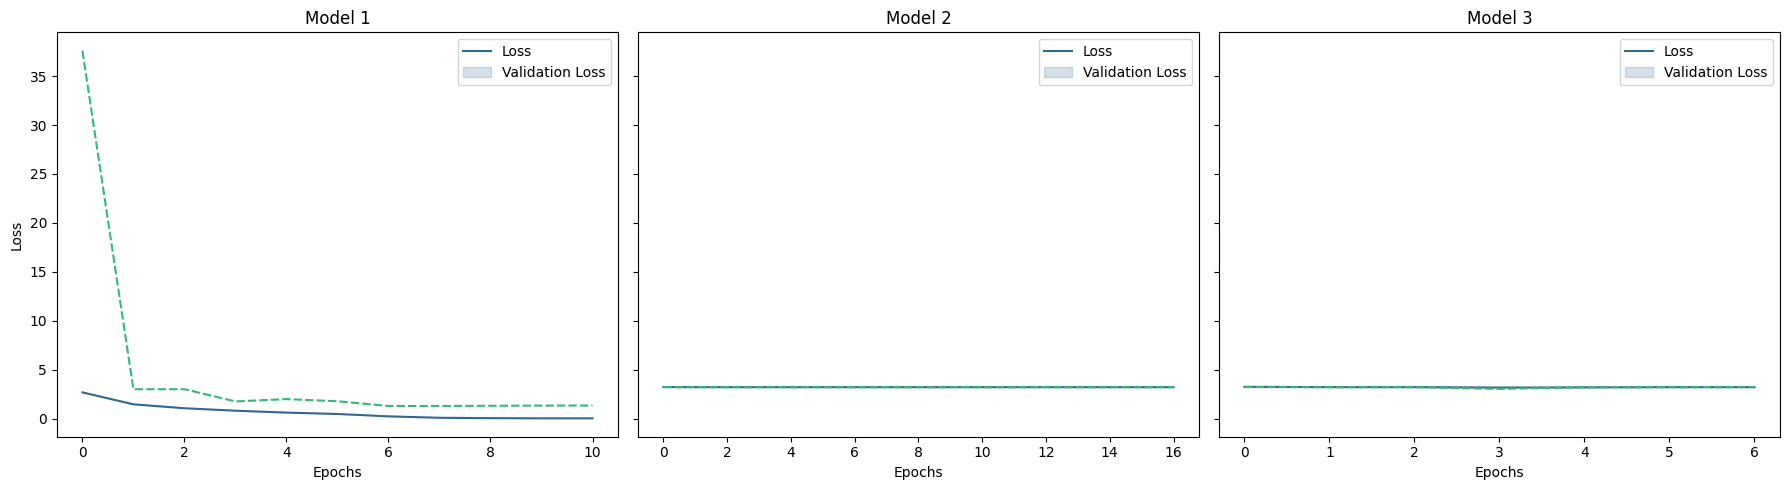

In [56]:
plot_multiple_histories([stft_mel_500_densenet[1], stft_mel_500_xception[1], stft_mel_500_vgg19[1]])

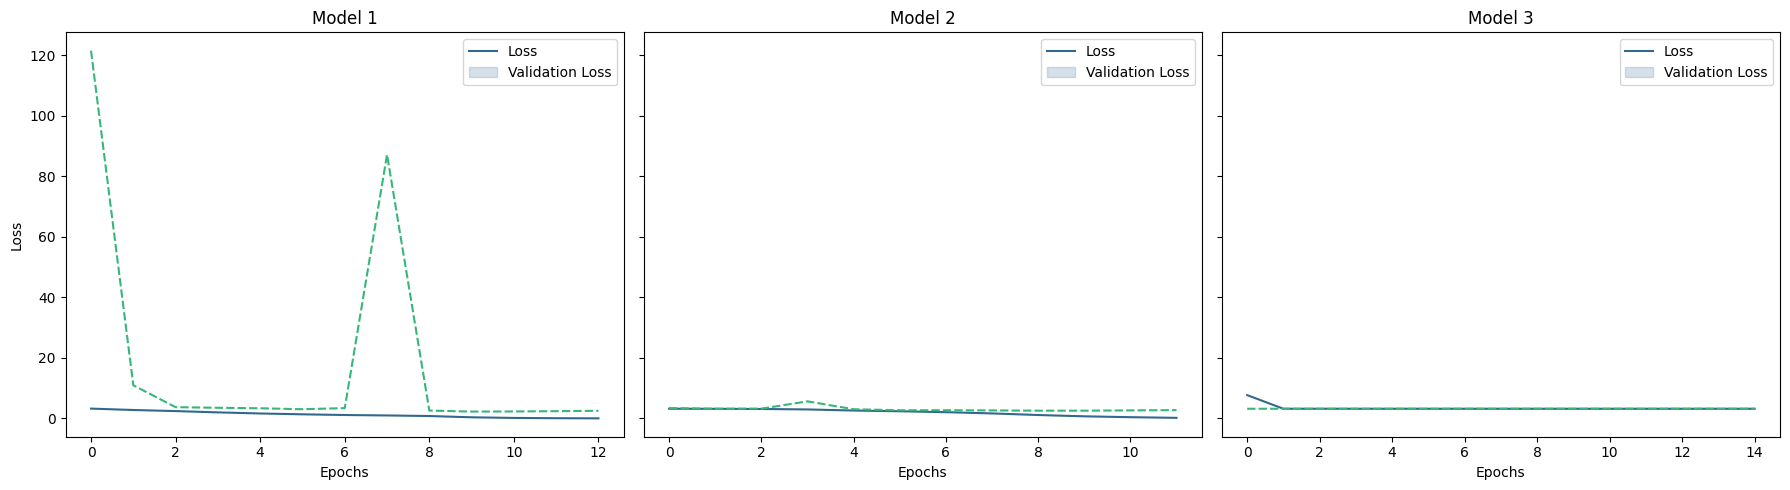

In [57]:
plot_multiple_histories([stft_mfcc_500_densenet[1], stft_mfcc_500_xception[1], stft_mfcc_500_vgg19[1]])

### 🌏 MFCC and Mel: All Classes

In [58]:
stft_mel_full_densenet, stft_mel_full_xception, stft_mel_full_vgg19 = train(path=train_stft_mel_full, learning_rate=0.001, epochs=50, output=len(class_names_stft_mel_full),
                                                                        validation=val_stft_mel_full ,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
116/116 [==============================] - 108s 881ms/step - loss: 3.9332 - accuracy: 0.1661 - mse: 0.0051 - val_loss: 5.4103 - val_accuracy: 0.1210 - val_mse: 0.0063 - lr: 0.0010
Epoch 2/50
116/116 [==============================] - 42s 365ms/step - loss: 2.7097 - accuracy: 0.3653 - mse: 0.0043 - val_loss: 3.3212 - val_accuracy: 0.3028 - val_mse: 0.0049 - lr: 0.0010
Epoch 3/50
116/116 [==============================] - 43s 367ms/step - loss: 2.2116 - accuracy: 0.4569 - mse: 0.0037 - val_loss: 2.9080 - val_accuracy: 0.3549 - val_mse: 0.0045 - lr: 0.0010
Epoch 4/50
116/116 [==============================] - 42s 361ms/step - loss: 1.8351 - accuracy: 0.5347 - mse: 0.0033 - val_loss: 2.9029 - val_accuracy: 0.3890 - val_mse: 0.0044 - lr: 0.0010
Epoch 5/50
116/116 [==============================] - 43s 366ms/step - loss: 1.5457 - accuracy: 0.5915 - mse: 0.0029 - val_loss: 2.7512 - val_accuracy: 0.4062 - val_mse: 0.0043 - lr: 0.0010
Epoch 6/50
116/116 [=============================

In [59]:
save_results(stft_mel_full_densenet, './models/stft_mel_full_densenet.h5', './hist/hist_stft_mel_full_densenet.csv',
            stft_mel_full_xception, './models/stft_mel_full_xception.h5', './hist/hist_stft_mel_full_xception.csv',
            stft_mel_full_vgg19, './models/stft_mel_full_vgg19.h5', './hist/hist_stft_mel_full_vgg19.csv')

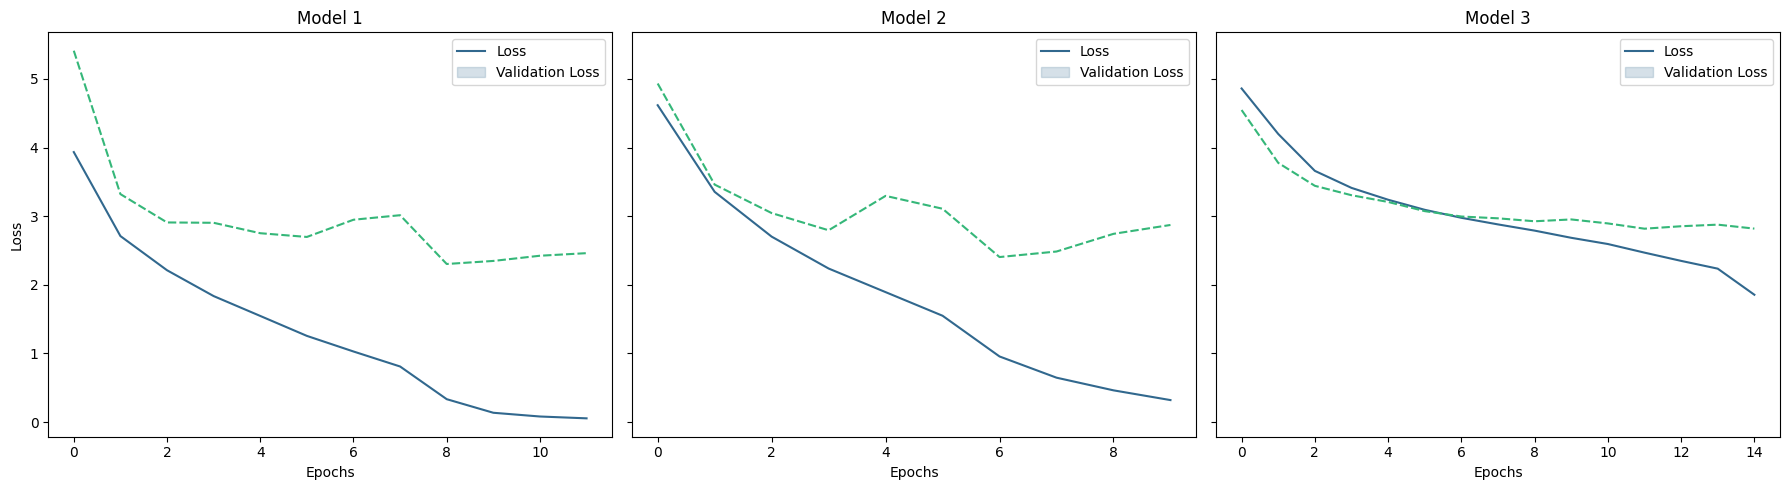

In [60]:
plot_multiple_histories([stft_mel_full_densenet[1], stft_mel_full_xception[1], stft_mel_full_vgg19[1]])

In [61]:
stft_mfcc_full_densenet, stft_mfcc_full_xception, stft_mfcc_full_vgg19 = train(path=train_stft_mfcc_full, learning_rate=0.001, epochs=50, output=len(class_names_stft_mfcc_full),
                                                                        validation=val_stft_mfcc_full,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

Epoch 1/50
116/116 [==============================] - 105s 842ms/step - loss: 4.6412 - accuracy: 0.0460 - mse: 0.0054 - val_loss: 5.3268 - val_accuracy: 0.0618 - val_mse: 0.0058 - lr: 0.0010
Epoch 2/50
116/116 [==============================] - 37s 319ms/step - loss: 4.1102 - accuracy: 0.1067 - mse: 0.0053 - val_loss: 4.5368 - val_accuracy: 0.0982 - val_mse: 0.0056 - lr: 0.0010
Epoch 3/50
116/116 [==============================] - 37s 320ms/step - loss: 3.7269 - accuracy: 0.1728 - mse: 0.0051 - val_loss: 6.1279 - val_accuracy: 0.0716 - val_mse: 0.0063 - lr: 0.0010
Epoch 4/50
116/116 [==============================] - ETA: 0s - loss: 3.4156 - accuracy: 0.2258 - mse: 0.0049
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
116/116 [==============================] - 37s 320ms/step - loss: 3.4156 - accuracy: 0.2258 - mse: 0.0049 - val_loss: 7.1861 - val_accuracy: 0.1528 - val_mse: 0.0057 - lr: 0.0010
Epoch 5/50
116/116 [==============================] - 37s 318ms

In [62]:
save_results(stft_mfcc_full_densenet, './models/stft_mfcc_full_densenet.h5', './hist/hist_stft_mfcc_full_densenet.csv',
            stft_mfcc_full_xception, './models/stft_mfcc_full_xception.h5', './hist/hist_stft_mfcc_full_xception.csv',
            stft_mfcc_full_vgg19, './models/stft_mfcc_full_vgg19.h5', './hist/hist_stft_mfcc_full_vgg19.csv')

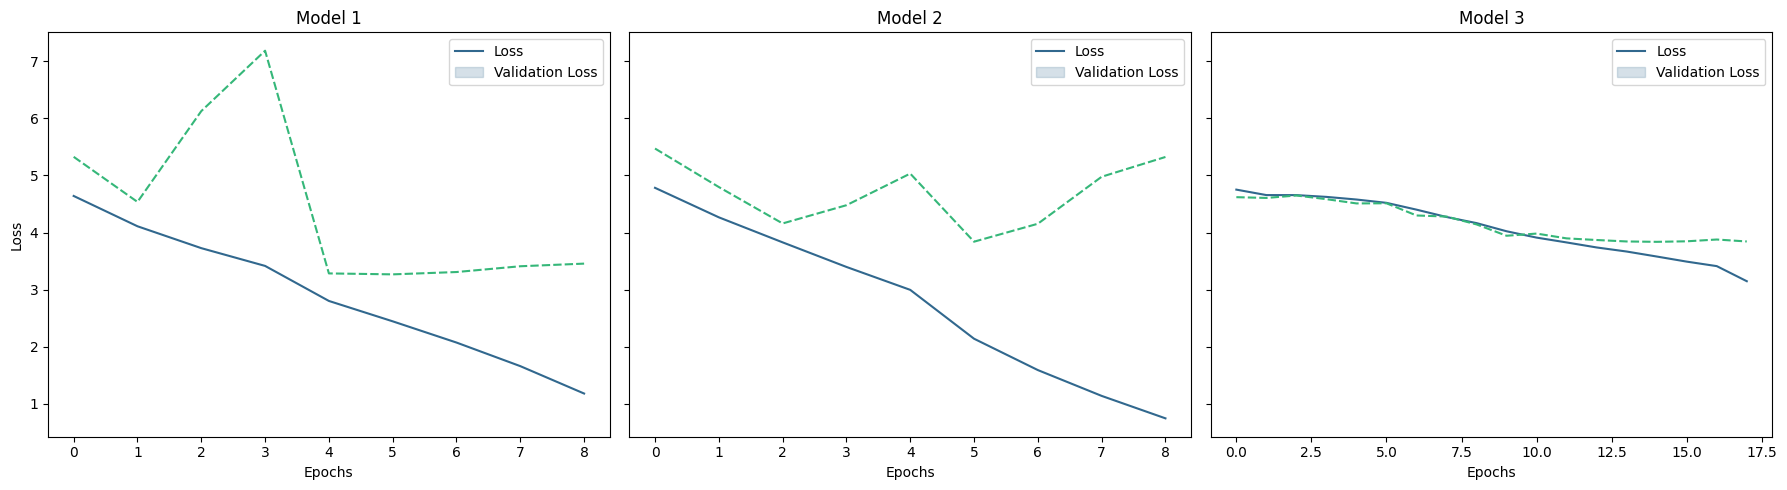

In [63]:
plot_multiple_histories([stft_mfcc_full_densenet[1], stft_mfcc_full_xception[1], stft_mfcc_full_vgg19[1]])

# 📝  Métricas

**Scores de Evaluación:**
- 📊 `Precisión`
$$Precisión = \frac{Verdaderos \: Positivos \: (TP)}{Verdaderos \: Positivos \: (TP) + Falsos \: positivos \: (FP)}$$
- 🔄 `Sensibilidad (Recall)`
$$Recall = \frac{Verdaderos \: Positivos \: (TP)}{Verdaderos \: Positivos \: (TP) + Falsos \: Negativos \: (FN)}$$
- ⚖️ `F1 Score`
$$F1 Score = 2 \times \frac{Precisión \times Recall}{Precisión + Recall}$$

### ⏳ Load models

📌**Nota**: Cargar los modelos sólo si es necesario.

In [3]:
simple_mfcc_densenet = [models.load_model('./models/simple_mfcc_densenet.h5')]
simple_mfcc_xception = [models.load_model('./models/simple_mfcc_xception.h5')]
simple_mfcc_vgg19 = [models.load_model('./models/simple_mfcc_vgg19.h5')]
#####################################################
normalized_densenet = [models.load_model('./models/normalized_densenet.h5')]
normalized_xception = [models.load_model('./models/normalized_xception.h5')]
normalized_vgg19 = [models.load_model('./models/normalized_vgg19.h5')]
#####################################################
filtered_densenet = [models.load_model('./models/filtered_densenet.h5')]
filtered_xception = [models.load_model('./models/filtered_xception.h5')]
filtered_vgg19 = [models.load_model('./models/filtered_vgg19.h5')]
#####################################################
stft_mfcc_1mn_densenet = [models.load_model('./models/stft_mfcc_1mn_densenet.h5')]
stft_mfcc_1mn_xception = [models.load_model('./models/stft_mfcc_1mn_xception.h5')]
stft_mfcc_1mn_vgg19 = [models.load_model('./models/stft_mfcc_1mn_vgg19.h5')]

stft_mel_1mn_densenet = [models.load_model('./models/stft_mel_1mn_densenet.h5')]
stft_mel_1mn_xception = [models.load_model('./models/stft_mel_1mn_xception.h5')]
stft_mel_1mn_vgg19 = [models.load_model('./models/stft_mel_1mn_vgg19.h5')]
####################################################
stft_mel_3mn_densenet = [models.load_model('./models/stft_mel_3mn_densenet.h5')]
stft_mel_3mn_xception = [models.load_model('./models/stft_mel_3mn_xception.h5')]
stft_mel_3mn_vgg19 = [models.load_model('./models/stft_mel_3mn_vgg19.h5')]

stft_mfcc_3mn_densenet = [models.load_model('./models/stft_mfcc_3mn_densenet.h5')]
stft_mfcc_3mn_xception = [models.load_model('./models/stft_mfcc_3mn_xception.h5')]
stft_mfcc_3mn_vgg19 = [models.load_model('./models/stft_mfcc_3mn_vgg19.h5')]
#####################################################
stft_mel_5mn_densenet = [models.load_model('./models/stft_mel_5mn_densenet.h5')]
stft_mel_5mn_xception = [models.load_model('./models/stft_mel_5mn_xception.h5')]
stft_mel_5mn_vgg19 = [models.load_model('./models/stft_mel_5mn_vgg19.h5')]

stft_mfcc_5mn_densenet = [models.load_model('./models/stft_mfcc_5mn_densenet.h5')]
stft_mfcc_5mn_xception = [models.load_model('./models/stft_mfcc_5mn_xception.h5')]
stft_mfcc_5mn_vgg19 = [models.load_model('./models/stft_mfcc_5mn_vgg19.h5')]
#####################################################
stft_mel_50_densenet = [models.load_model('./models/stft_mel_50_densenet.h5')]
stft_mel_50_xception = [models.load_model('./models/stft_mel_50_xception.h5')]
stft_mel_50_vgg19 = [models.load_model('./models/stft_mel_50_vgg19.h5')]

stft_mfcc_50_densenet = [models.load_model('./models/stft_mfcc_50_densenet.h5')]
stft_mfcc_50_xception = [models.load_model('./models/stft_mfcc_50_xception.h5')]
stft_mfcc_50_vgg19 = [models.load_model('./models/stft_mfcc_50_vgg19.h5')]
#####################################################
stft_mel_100_densenet = [models.load_model('./models/stft_mel_100_densenet.h5')]
stft_mel_100_xception = [models.load_model('./models/stft_mel_100_xception.h5')]
stft_mel_100_vgg19 = [models.load_model('./models/stft_mel_100_vgg19.h5')]

stft_mfcc_100_densenet = [models.load_model('./models/stft_mfcc_100_densenet.h5')]
stft_mfcc_100_xception = [models.load_model('./models/stft_mfcc_100_xception.h5')]
stft_mfcc_100_vgg19 = [models.load_model('./models/stft_mfcc_100_vgg19.h5')]
#####################################################
stft_mel_500_densenet = [models.load_model('./models/stft_mel_500_densenet.h5')]
stft_mel_500_xception = [models.load_model('./models/stft_mel_500_xception.h5')]
stft_mel_500_vgg19 = [models.load_model('./models/stft_mel_500_vgg19.h5')]

stft_mfcc_500_densenet = [models.load_model('./models/stft_mfcc_500_densenet.h5')]
stft_mfcc_500_xception = [models.load_model('./models/stft_mfcc_500_xception.h5')]
stft_mfcc_500_vgg19 = [models.load_model('./models/stft_mfcc_500_vgg19.h5')]
#####################################################
stft_mel_full_densenet = [models.load_model('./models/stft_mel_full_densenet.h5')]
stft_mel_full_xception = [models.load_model('./models/stft_mel_full_xception.h5')]
stft_mel_full_vgg19 = [models.load_model('./models/stft_mel_full_vgg19.h5')]
#####################################################
stft_mfcc_full_densenet = [models.load_model('./models/stft_mfcc_full_densenet.h5')]
stft_mfcc_full_xception = [models.load_model('./models/stft_mfcc_full_xception.h5')]
stft_mfcc_full_vgg19 = [models.load_model('./models/stft_mfcc_full_vgg19.h5')]
#####################################################

### 📈📉 Scores

In [4]:
def pred_and_test(model, test_gen):
    y_pred = model.predict(test_gen)
    y_pred_classes = np.argmax(y_pred, axis=1)

    return y_pred, y_pred_classes

In [5]:
def get_labels(test):
    for i in range(len(test)):
        if i == 0:
            labels = test[i][1]
        else:
            labels = np.concatenate([labels, test[i][1]])

    return labels

In [6]:
def new_f1_score(model, test_gen):
    
    y_pred, y_pred_classes = pred_and_test(model, test_gen)

    # Obtener las etiquetas verdaderas
    labels = get_labels(test_gen)
   
    y_true = np.argmax(labels, axis=1)

    # Calcular el F1 score (macro, micro o weighted según lo que necesites)
    f1 = f1_score(y_true, y_pred_classes, average='macro')
    print(f'F1 Score (weighted): {f1:.4f}')

    # También puedes imprimir un informe de clasificación completo
    print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

    return classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()), f1

### 🎶 Simple MFCC Images Scores

In [81]:
report_simple_mfcc_densenet, f1_simple_mfcc_densenet = new_f1_score(simple_mfcc_densenet[0], test_stft_mel_full)

38/38 [==============================] - 10s 260ms/step
F1 Score (weighted): 0.0023
              precision    recall  f1-score   support

      asbfly       0.00      0.00      0.00        21
     ashdro1       0.00      0.00      0.00        21
     ashpri1       0.00      0.00      0.00        19
     ashwoo2       0.00      0.00      0.00         9
     asikoe2       0.00      0.00      0.00        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       0.00      0.00      0.00         5
     barfly1       0.00      0.00      0.00         4
      barswa       0.00      0.00      0.00       100
      bcnher       0.04      0.01      0.02       100
     bkcbul1       0.00      0.00      0.00         4
     bkrfla1       0.00      0.00      0.00         5
     bkskit1       0.00      0.00      0.00        53
      bkwsti       0.14      0.01      0.02       100
     bladro1       0.00      0.00      0.00        

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [71]:
report_simple_mfcc_xception, f1_simple_mfcc_xception = new_f1_score(simple_mfcc_xception[0], test_stft_mel_full)

38/38 [==============================] - 10s 261ms/step
F1 Score (weighted): 0.0042
              precision    recall  f1-score   support

      asbfly       0.00      0.00      0.00        21
     ashdro1       0.00      0.00      0.00        21
     ashpri1       0.00      0.00      0.00        19
     ashwoo2       0.00      0.00      0.00         9
     asikoe2       0.00      0.00      0.00        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       0.00      0.00      0.00         5
     barfly1       0.00      0.00      0.00         4
      barswa       0.01      0.01      0.01       100
      bcnher       0.14      0.12      0.13       100
     bkcbul1       0.00      0.00      0.00         4
     bkrfla1       0.00      0.00      0.00         5
     bkskit1       0.00      0.00      0.00        53
      bkwsti       0.00      0.00      0.00       100
     bladro1       0.00      0.00      0.00        

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [72]:
report_simple_mfcc_vgg19, f1_simple_mfcc_vgg19 = new_f1_score(simple_mfcc_vgg19[0], test_stft_mel_full)

38/38 [==============================] - 10s 264ms/step
F1 Score (weighted): 0.0044
              precision    recall  f1-score   support

      asbfly       0.00      0.00      0.00        21
     ashdro1       0.00      0.00      0.00        21
     ashpri1       0.00      0.00      0.00        19
     ashwoo2       0.00      0.00      0.00         9
     asikoe2       0.00      0.00      0.00        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       0.00      0.00      0.00         5
     barfly1       0.00      0.00      0.00         4
      barswa       0.00      0.00      0.00       100
      bcnher       0.03      0.06      0.04       100
     bkcbul1       0.00      0.00      0.00         4
     bkrfla1       0.00      0.00      0.00         5
     bkskit1       0.00      0.00      0.00        53
      bkwsti       0.00      0.00      0.00       100
     bladro1       0.00      0.00      0.00        

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

### ➗ Normalized Images Scores

In [82]:
report_normalized_densenet, f1_normalized_densenet = new_f1_score(normalized_densenet[0], test_normlized)

38/38 [==============================] - 17s 429ms/step
F1 Score (weighted): 0.1954
              precision    recall  f1-score   support

      asbfly       0.00      0.00      0.00        21
     ashdro1       0.07      0.10      0.08        21
     ashpri1       0.33      0.11      0.16        19
     ashwoo2       0.25      0.11      0.15         9
     asikoe2       0.16      0.20      0.18        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       0.00      0.00      0.00         5
     barfly1       0.00      0.00      0.00         4
      barswa       0.59      0.50      0.54       100
      bcnher       0.28      0.39      0.33       100
     bkcbul1       0.00      0.00      0.00         4
     bkrfla1       1.00      0.60      0.75         5
     bkskit1       0.78      0.47      0.59        53
      bkwsti       0.76      0.64      0.70       100
     bladro1       0.11      0.08      0.09        

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [83]:
report_normalized_xception, f1_normalized_xception = new_f1_score(normalized_xception[0], test_normlized)

38/38 [==============================] - 3s 75ms/step
F1 Score (weighted): 0.1679
              precision    recall  f1-score   support

      asbfly       0.13      0.10      0.11        21
     ashdro1       0.00      0.00      0.00        21
     ashpri1       0.07      0.05      0.06        19
     ashwoo2       0.67      0.22      0.33         9
     asikoe2       0.16      0.18      0.17        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       1.00      0.40      0.57         5
     barfly1       0.00      0.00      0.00         4
      barswa       0.45      0.41      0.43       100
      bcnher       0.22      0.54      0.31       100
     bkcbul1       0.00      0.00      0.00         4
     bkrfla1       0.75      0.60      0.67         5
     bkskit1       0.58      0.49      0.53        53
      bkwsti       0.75      0.52      0.62       100
     bladro1       0.11      0.04      0.06        25

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [84]:
report_normalized_vgg19, f1_normalized_vgg19 = new_f1_score(normalized_vgg19[0], test_normlized)

38/38 [==============================] - 3s 76ms/step
F1 Score (weighted): 0.0002
              precision    recall  f1-score   support

      asbfly       0.00      0.00      0.00        21
     ashdro1       0.00      0.00      0.00        21
     ashpri1       0.00      0.00      0.00        19
     ashwoo2       0.00      0.00      0.00         9
     asikoe2       0.00      0.00      0.00        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       0.00      0.00      0.00         5
     barfly1       0.00      0.00      0.00         4
      barswa       0.00      0.00      0.00       100
      bcnher       0.00      0.00      0.00       100
     bkcbul1       0.00      0.00      0.00         4
     bkrfla1       0.00      0.00      0.00         5
     bkskit1       0.00      0.00      0.00        53
      bkwsti       0.00      0.00      0.00       100
     bladro1       0.00      0.00      0.00        25

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

### 🔲 Filtered Images Scores

In [85]:
report_filtered_densenet, f1_filtered_densenet = new_f1_score(filtered_densenet[0], test_filtered)

38/38 [==============================] - 17s 432ms/step
F1 Score (weighted): 0.1509
              precision    recall  f1-score   support

      asbfly       0.00      0.00      0.00        21
     ashdro1       0.25      0.05      0.08        21
     ashpri1       0.20      0.05      0.08        19
     ashwoo2       0.00      0.00      0.00         9
     asikoe2       0.20      0.22      0.21        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       0.00      0.00      0.00         5
     barfly1       0.00      0.00      0.00         4
      barswa       0.35      0.34      0.34       100
      bcnher       0.23      0.42      0.30       100
     bkcbul1       0.00      0.00      0.00         4
     bkrfla1       0.00      0.00      0.00         5
     bkskit1       0.55      0.34      0.42        53
      bkwsti       0.58      0.62      0.60       100
     bladro1       0.00      0.00      0.00        

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [86]:
report_filtered_xception, f1_filtered_xception = new_f1_score(filtered_xception[0], test_filtered)

38/38 [==============================] - 3s 75ms/step
F1 Score (weighted): 0.1439
              precision    recall  f1-score   support

      asbfly       0.00      0.00      0.00        21
     ashdro1       0.00      0.00      0.00        21
     ashpri1       0.07      0.11      0.09        19
     ashwoo2       0.00      0.00      0.00         9
     asikoe2       0.12      0.25      0.17        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       0.00      0.00      0.00         5
     barfly1       0.00      0.00      0.00         4
      barswa       0.31      0.34      0.33       100
      bcnher       0.22      0.41      0.29       100
     bkcbul1       0.00      0.00      0.00         4
     bkrfla1       0.50      0.40      0.44         5
     bkskit1       0.45      0.25      0.32        53
      bkwsti       0.45      0.62      0.52       100
     bladro1       0.00      0.00      0.00        25

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [87]:
report_filtered_vgg19, f1_filtered_vgg19 = new_f1_score(filtered_vgg19[0], test_filtered)

38/38 [==============================] - 3s 74ms/step
F1 Score (weighted): 0.0002
              precision    recall  f1-score   support

      asbfly       0.00      0.00      0.00        21
     ashdro1       0.00      0.00      0.00        21
     ashpri1       0.00      0.00      0.00        19
     ashwoo2       0.00      0.00      0.00         9
     asikoe2       0.00      0.00      0.00        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       0.00      0.00      0.00         5
     barfly1       0.00      0.00      0.00         4
      barswa       0.00      0.00      0.00       100
      bcnher       0.00      0.00      0.00       100
     bkcbul1       0.00      0.00      0.00         4
     bkrfla1       0.00      0.00      0.00         5
     bkskit1       0.00      0.00      0.00        53
      bkwsti       0.00      0.00      0.00       100
     bladro1       0.00      0.00      0.00        25

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

### 🕜 STFT Mel and MFCC 1 minute Images Scores

In [88]:
report_stft_mel_1mn_densenet, f1_stft_mel_1mn_densenet = new_f1_score(stft_mel_1mn_densenet[0], test_stft_mel_1mn)

5/5 [==============================] - 4s 625ms/step
F1 Score (weighted): 0.4066
              precision    recall  f1-score   support

     asikoe2       0.92      0.86      0.89        14
      barswa       0.33      0.27      0.30        22
      bcnher       0.41      0.52      0.46        23
      bkwsti       0.71      0.68      0.69        25
     blrwar1       0.47      0.35      0.40        23
      comgre       0.42      0.59      0.49        17
     comior1       0.10      0.07      0.08        14
     comkin1       0.38      0.38      0.38        13
     commoo3       0.00      0.00      0.00        14
      commyn       0.17      0.18      0.17        11
      comros       0.43      0.72      0.54        29
      comsan       0.45      0.53      0.49        17
     comtai1       0.29      0.17      0.21        12
     eaywag1       0.33      0.21      0.26        19
      eucdov       0.88      0.88      0.88        17
      eurcoo       0.50      0.36      0.42        14


In [89]:
report_stft_mel_1mn_xception, f1_stft_mel_1mn_xception = new_f1_score(stft_mel_1mn_xception[0], test_stft_mel_1mn)

5/5 [==============================] - 2s 250ms/step
F1 Score (weighted): 0.0030
              precision    recall  f1-score   support

     asikoe2       0.00      0.00      0.00        14
      barswa       0.00      0.00      0.00        22
      bcnher       0.00      0.00      0.00        23
      bkwsti       0.00      0.00      0.00        25
     blrwar1       0.00      0.00      0.00        23
      comgre       0.00      0.00      0.00        17
     comior1       0.00      0.00      0.00        14
     comkin1       0.00      0.00      0.00        13
     commoo3       0.00      0.00      0.00        14
      commyn       0.00      0.00      0.00        11
      comros       0.00      0.00      0.00        29
      comsan       0.00      0.00      0.00        17
     comtai1       0.00      0.00      0.00        12
     eaywag1       0.00      0.00      0.00        19
      eucdov       0.00      0.00      0.00        17
      eurcoo       0.00      0.00      0.00        14


c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [93]:
report_stft_mel_1mn_vgg19, f1_stft_mel_1mn_vgg19 = new_f1_score(stft_mel_1mn_vgg19[0], test_stft_mel_1mn)

5/5 [==============================] - 1s 245ms/step
F1 Score (weighted): 0.2235
              precision    recall  f1-score   support

     asikoe2       0.79      0.79      0.79        14
      barswa       0.12      0.18      0.15        22
      bcnher       0.53      0.43      0.48        23
      bkwsti       0.25      0.64      0.36        25
     blrwar1       0.15      0.39      0.22        23
      comgre       0.43      0.35      0.39        17
     comior1       0.20      0.07      0.11        14
     comkin1       0.00      0.00      0.00        13
     commoo3       0.00      0.00      0.00        14
      commyn       0.00      0.00      0.00        11
      comros       0.47      0.69      0.56        29
      comsan       0.17      0.06      0.09        17
     comtai1       0.00      0.00      0.00        12
     eaywag1       0.00      0.00      0.00        19
      eucdov       0.00      0.00      0.00        17
      eurcoo       0.40      0.29      0.33        14


c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [92]:
report_stft_mfcc_1mn_densenet, f1_stft_mfcc_1mn_densenet = new_f1_score(stft_mfcc_1mn_densenet[0], test_stft_mfcc_1mn)

5/5 [==============================] - 2s 226ms/step
F1 Score (weighted): 0.0119
              precision    recall  f1-score   support

     asikoe2       0.00      0.00      0.00        14
      barswa       0.00      0.00      0.00        22
      bcnher       0.00      0.00      0.00        23
      bkwsti       0.05      0.20      0.08        25
     blrwar1       0.02      0.04      0.02        23
      comgre       0.00      0.00      0.00        17
     comior1       0.00      0.00      0.00        14
     comkin1       0.00      0.00      0.00        13
     commoo3       0.00      0.00      0.00        14
      commyn       0.00      0.00      0.00        11
      comros       0.10      0.24      0.14        29
      comsan       0.00      0.00      0.00        17
     comtai1       0.00      0.00      0.00        12
     eaywag1       0.00      0.00      0.00        19
      eucdov       0.00      0.00      0.00        17
      eurcoo       0.00      0.00      0.00        14


c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [91]:
report_stft_mfcc_1mn_xception, f1_stft_mfcc_1mn_xception = new_f1_score(stft_mfcc_1mn_xception[0], test_stft_mfcc_1mn)

5/5 [==============================] - 2s 228ms/step
F1 Score (weighted): 0.0030
              precision    recall  f1-score   support

     asikoe2       0.00      0.00      0.00        14
      barswa       0.00      0.00      0.00        22
      bcnher       0.00      0.00      0.00        23
      bkwsti       0.00      0.00      0.00        25
     blrwar1       0.00      0.00      0.00        23
      comgre       0.00      0.00      0.00        17
     comior1       0.00      0.00      0.00        14
     comkin1       0.00      0.00      0.00        13
     commoo3       0.00      0.00      0.00        14
      commyn       0.00      0.00      0.00        11
      comros       0.00      0.00      0.00        29
      comsan       0.00      0.00      0.00        17
     comtai1       0.00      0.00      0.00        12
     eaywag1       0.00      0.00      0.00        19
      eucdov       0.00      0.00      0.00        17
      eurcoo       0.00      0.00      0.00        14


c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [90]:
report_stft_mfcc_1mn_vgg19, f1_stft_mfcc_1mn_vgg19 = new_f1_score(stft_mfcc_1mn_vgg19[0], test_stft_mfcc_1mn)

5/5 [==============================] - 3s 571ms/step
F1 Score (weighted): 0.0104
              precision    recall  f1-score   support

     asikoe2       0.00      0.00      0.00        14
      barswa       0.00      0.00      0.00        22
      bcnher       0.08      0.30      0.13        23
      bkwsti       0.00      0.00      0.00        25
     blrwar1       0.00      0.00      0.00        23
      comgre       0.00      0.00      0.00        17
     comior1       0.00      0.00      0.00        14
     comkin1       0.00      0.00      0.00        13
     commoo3       0.00      0.00      0.00        14
      commyn       0.00      0.00      0.00        11
      comros       0.00      0.00      0.00        29
      comsan       0.00      0.00      0.00        17
     comtai1       0.00      0.00      0.00        12
     eaywag1       0.00      0.00      0.00        19
      eucdov       0.00      0.00      0.00        17
      eurcoo       0.00      0.00      0.00        14


c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

### 🕒 STFT Mel and MFCC 3 minute Images Scores

#### bests

In [94]:
report_stft_mel_3mn_densenet, f1_stft_mel_3mn_densenet = new_f1_score(stft_mel_3mn_densenet[0], test_stft_mel_3mn)

5/5 [==============================] - 4s 698ms/step
F1 Score (weighted): 0.8334
              precision    recall  f1-score   support

      barswa       0.76      0.86      0.81        29
      bcnher       0.74      0.87      0.80        23
     bkskit1       0.81      1.00      0.90        13
      bkwsti       0.79      0.73      0.76        26
     blrwar1       0.89      0.89      0.89        70
      comgre       0.92      0.79      0.85        14
     comkin1       0.94      0.94      0.94        16
      commyn       0.87      0.81      0.84        16
      comros       0.80      0.91      0.85        53
     eaywag1       0.86      0.79      0.83        24
      eucdov       0.92      0.85      0.88        26
      eurcoo       0.58      0.54      0.56        13
     graher1       0.79      0.83      0.81        18
     grewar3       0.97      0.92      0.95        38
     grtdro1       0.85      0.81      0.83        21
      grywag       0.83      0.79      0.81        24


In [95]:
report_stft_mel_3mn_xception, f1_stft_mel_3mn_xception = new_f1_score(stft_mel_3mn_xception[0], test_stft_mel_3mn)

5/5 [==============================] - 2s 277ms/step
F1 Score (weighted): 0.8352
              precision    recall  f1-score   support

      barswa       0.96      0.79      0.87        29
      bcnher       0.79      0.83      0.81        23
     bkskit1       0.75      0.92      0.83        13
      bkwsti       0.88      0.85      0.86        26
     blrwar1       0.88      0.87      0.88        70
      comgre       0.83      0.71      0.77        14
     comkin1       0.82      0.88      0.85        16
      commyn       0.65      0.69      0.67        16
      comros       0.85      0.98      0.91        53
     eaywag1       0.87      0.83      0.85        24
      eucdov       0.92      0.85      0.88        26
      eurcoo       0.64      0.54      0.58        13
     graher1       0.71      0.94      0.81        18
     grewar3       0.90      0.95      0.92        38
     grtdro1       0.90      0.90      0.90        21
      grywag       0.95      0.83      0.89        24


In [ ]:
report_stft_mel_3mn_vgg19, f1_stft_mel_3mn_vgg19 = new_f1_score(stft_mel_3mn_vgg19[0], test_stft_mel_3mn)

5/5 [==============================] - 2s 449ms/step
F1 Score (weighted): 0.6556
              precision    recall  f1-score   support

      barswa       0.56      0.66      0.60        29
      bcnher       0.78      0.91      0.84        23
     bkskit1       0.67      0.62      0.64        13
      bkwsti       0.78      0.81      0.79        26
     blrwar1       0.74      0.74      0.74        70
      comgre       0.44      0.57      0.50        14
     comkin1       0.86      0.75      0.80        16
      commyn       0.47      0.50      0.48        16
      comros       0.82      0.79      0.81        53
     eaywag1       0.70      0.67      0.68        24
      eucdov       0.95      0.77      0.85        26
      eurcoo       0.42      0.38      0.40        13
     graher1       0.70      0.89      0.78        18
     grewar3       0.70      0.82      0.76        38
     grtdro1       0.73      0.76      0.74        21
      grywag       0.64      0.58      0.61        24


In [ ]:
report_stft_mfcc_3mn_densenet, f1_stft_mfcc_3mn_densenet = new_f1_score(stft_mfcc_3mn_densenet[0], test_stft_mfcc_3mn)

5/5 [==============================] - 2s 270ms/step
F1 Score (weighted): 0.8372
              precision    recall  f1-score   support

      barswa       0.81      0.86      0.83        29
      bcnher       0.73      0.83      0.78        23
     bkskit1       0.93      1.00      0.96        13
      bkwsti       0.84      0.81      0.82        26
     blrwar1       0.83      0.84      0.84        70
      comgre       0.71      0.71      0.71        14
     comkin1       0.82      0.88      0.85        16
      commyn       0.93      0.81      0.87        16
      comros       0.79      0.91      0.84        53
     eaywag1       0.95      0.83      0.89        24
      eucdov       0.92      0.85      0.88        26
      eurcoo       0.60      0.46      0.52        13
     graher1       0.80      0.89      0.84        18
     grewar3       0.90      0.92      0.91        38
     grtdro1       0.89      0.81      0.85        21
      grywag       0.95      0.83      0.89        24


In [ ]:
report_stft_mfcc_3mn_xception, f1_stft_mfcc_3mn_xception = new_f1_score(stft_mfcc_3mn_xception[0], test_stft_mfcc_3mn)

5/5 [==============================] - 2s 261ms/step
F1 Score (weighted): 0.8047
              precision    recall  f1-score   support

      barswa       0.86      0.83      0.84        29
      bcnher       0.88      0.65      0.75        23
     bkskit1       1.00      0.92      0.96        13
      bkwsti       0.81      0.65      0.72        26
     blrwar1       0.91      0.84      0.87        70
      comgre       1.00      0.64      0.78        14
     comkin1       0.88      0.88      0.88        16
      commyn       0.67      0.75      0.71        16
      comros       0.86      0.92      0.89        53
     eaywag1       0.65      0.83      0.73        24
      eucdov       0.95      0.81      0.88        26
      eurcoo       0.33      0.54      0.41        13
     graher1       1.00      0.67      0.80        18
     grewar3       0.97      0.89      0.93        38
     grtdro1       1.00      0.86      0.92        21
      grywag       0.87      0.83      0.85        24


In [99]:
report_stft_mfcc_3mn_vgg19, f1_stft_mfcc_3mn_vgg19 = new_f1_score(stft_mfcc_3mn_vgg19[0], test_stft_mfcc_3mn)

5/5 [==============================] - 1s 265ms/step
F1 Score (weighted): 0.5341
              precision    recall  f1-score   support

      barswa       0.46      0.55      0.50        29
      bcnher       0.90      0.83      0.86        23
     bkskit1       0.18      0.15      0.17        13
      bkwsti       0.47      0.69      0.56        26
     blrwar1       0.70      0.63      0.66        70
      comgre       0.29      0.43      0.34        14
     comkin1       0.62      0.50      0.55        16
      commyn       0.57      0.25      0.35        16
      comros       0.71      0.87      0.78        53
     eaywag1       0.47      0.62      0.54        24
      eucdov       0.78      0.69      0.73        26
      eurcoo       0.54      0.54      0.54        13
     graher1       0.67      0.67      0.67        18
     grewar3       0.64      0.74      0.68        38
     grtdro1       0.70      0.76      0.73        21
      grywag       0.68      0.62      0.65        24


c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

### 🕠 STFT Mel and MFCC 5 minute Images Scores

In [100]:
report_stft_mel_5mn_densenet, f1_stft_mel_5mn_densenet = new_f1_score(stft_mel_5mn_densenet[0], test_stft_mel_5mn)

1/1 [==============================] - 1s 1s/step
F1 Score (weighted): 0.1719
              precision    recall  f1-score   support

     blrwar1       0.38      0.83      0.53         6
      comros       0.00      0.00      0.00         2
     grewar3       0.00      0.00      0.00         4
      hoopoe       0.00      0.00      0.00         2
      houspa       0.33      0.33      0.33         3

    accuracy                           0.35        17
   macro avg       0.14      0.23      0.17        17
weighted avg       0.19      0.35      0.24        17



c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [101]:
report_stft_mel_5mn_xception, f1_stft_mel_5mn_xception = new_f1_score(stft_mel_5mn_xception[0], test_stft_mel_5mn)

1/1 [==============================] - 0s 467ms/step
F1 Score (weighted): 0.0857
              precision    recall  f1-score   support

     blrwar1       0.38      0.50      0.43         6
      comros       0.00      0.00      0.00         2
     grewar3       0.00      0.00      0.00         4
      hoopoe       0.00      0.00      0.00         2
      houspa       0.00      0.00      0.00         3

    accuracy                           0.18        17
   macro avg       0.07      0.10      0.09        17
weighted avg       0.13      0.18      0.15        17



c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [102]:
report_stft_mel_5mn_vgg19, f1_stft_mel_5mn_vgg19 = new_f1_score(stft_mel_5mn_vgg19[0], test_stft_mel_5mn)

1/1 [==============================] - 0s 135ms/step
F1 Score (weighted): 0.1043
              precision    recall  f1-score   support

     blrwar1       0.35      1.00      0.52         6
      comros       0.00      0.00      0.00         2
     grewar3       0.00      0.00      0.00         4
      hoopoe       0.00      0.00      0.00         2
      houspa       0.00      0.00      0.00         3

    accuracy                           0.35        17
   macro avg       0.07      0.20      0.10        17
weighted avg       0.12      0.35      0.18        17



c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [103]:
report_stft_mfcc_5mn_densenet, f1_stft_mfcc_5mn_densenet = new_f1_score(stft_mfcc_5mn_densenet[0], test_stft_mfcc_5mn)

1/1 [==============================] - 1s 1s/step
F1 Score (weighted): 0.0235
              precision    recall  f1-score   support

     blrwar1       0.00      0.00      0.00         6
      comros       0.00      0.00      0.00         2
     grewar3       0.08      0.25      0.12         4
      hoopoe       0.00      0.00      0.00         2
      houspa       0.00      0.00      0.00         3

    accuracy                           0.06        17
   macro avg       0.02      0.05      0.02        17
weighted avg       0.02      0.06      0.03        17



c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [104]:
report_stft_mfcc_5mn_xception, f1_stft_mfcc_5mn_xception = new_f1_score(stft_mfcc_5mn_xception[0], test_stft_mfcc_5mn)

1/1 [==============================] - 0s 452ms/step
F1 Score (weighted): 0.1467
              precision    recall  f1-score   support

     blrwar1       0.00      0.00      0.00         6
      comros       0.00      0.00      0.00         2
     grewar3       0.00      0.00      0.00         4
      hoopoe       0.25      1.00      0.40         2
      houspa       0.22      0.67      0.33         3

    accuracy                           0.24        17
   macro avg       0.09      0.33      0.15        17
weighted avg       0.07      0.24      0.11        17



c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [105]:
report_stft_mfcc_5mn_vgg19, f1_stft_mfcc_5mn_vgg19 = new_f1_score(stft_mfcc_5mn_vgg19[0], test_stft_mfcc_5mn)

1/1 [==============================] - 0s 138ms/step
F1 Score (weighted): 0.1043
              precision    recall  f1-score   support

     blrwar1       0.35      1.00      0.52         6
      comros       0.00      0.00      0.00         2
     grewar3       0.00      0.00      0.00         4
      hoopoe       0.00      0.00      0.00         2
      houspa       0.00      0.00      0.00         3

    accuracy                           0.35        17
   macro avg       0.07      0.20      0.10        17
weighted avg       0.12      0.35      0.18        17



c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

### 🪫 STFT Mel and MFCC: Groups with 50 &le; Images &le; 99 Scores

In [106]:
report_stft_mel_50_densenet, f1_stft_mel_50_densenet = new_f1_score(stft_mel_50_densenet[0], test_stft_mel_50)

3/3 [==============================] - 2s 623ms/step
F1 Score (weighted): 0.0126
              precision    recall  f1-score   support

     ashpri1       0.00      0.00      0.00        19
     brcful1       0.00      0.00      0.00        17
     brwowl1       0.00      0.00      0.00        15
     btbeat1       0.00      0.00      0.00        11
     cohcuc1       0.00      0.00      0.00        15
      compea       0.00      0.00      0.00        14
     emedov2       0.18      0.20      0.19        10
     grbeat1       0.02      0.23      0.04        13
     grefla1       0.00      0.00      0.00        11
     grejun2       0.00      0.00      0.00        10
      gryfra       0.00      0.00      0.00        11
     inbrob1       0.03      0.18      0.05        11
     indpit1       0.00      0.00      0.00        12
     insbab1       0.00      0.00      0.00        12
     junbab2       0.00      0.00      0.00        15
     lblwar1       0.00      0.00      0.00        18


c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [107]:
report_stft_mel_50_xception, f1_stft_mel_50_xception = new_f1_score(stft_mel_50_xception[0], test_stft_mel_50)

3/3 [==============================] - 1s 261ms/step
F1 Score (weighted): 0.0114
              precision    recall  f1-score   support

     ashpri1       0.05      0.37      0.09        19
     brcful1       0.00      0.00      0.00        17
     brwowl1       0.00      0.00      0.00        15
     btbeat1       0.00      0.00      0.00        11
     cohcuc1       0.00      0.00      0.00        15
      compea       0.00      0.00      0.00        14
     emedov2       0.00      0.00      0.00        10
     grbeat1       0.00      0.00      0.00        13
     grefla1       0.00      0.00      0.00        11
     grejun2       0.00      0.00      0.00        10
      gryfra       0.00      0.00      0.00        11
     inbrob1       0.00      0.00      0.00        11
     indpit1       0.00      0.00      0.00        12
     insbab1       0.00      0.00      0.00        12
     junbab2       0.00      0.00      0.00        15
     lblwar1       0.00      0.00      0.00        18


c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [108]:
report_stft_mel_50_vgg19, f1_stft_mel_50_vgg19 = new_f1_score(stft_mel_50_vgg19[0], test_stft_mel_50)

3/3 [==============================] - 1s 251ms/step
F1 Score (weighted): 0.3445
              precision    recall  f1-score   support

     ashpri1       0.20      0.16      0.18        19
     brcful1       0.56      0.29      0.38        17
     brwowl1       0.50      0.40      0.44        15
     btbeat1       0.00      0.00      0.00        11
     cohcuc1       0.65      0.87      0.74        15
      compea       0.48      0.79      0.59        14
     emedov2       0.50      0.40      0.44        10
     grbeat1       0.29      0.15      0.20        13
     grefla1       0.11      0.09      0.10        11
     grejun2       0.40      0.20      0.27        10
      gryfra       0.29      0.18      0.22        11
     inbrob1       0.25      0.36      0.30        11
     indpit1       0.00      0.00      0.00        12
     insbab1       0.75      0.75      0.75        12
     junbab2       0.26      0.47      0.33        15
     lblwar1       0.31      0.61      0.42        18


c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [109]:
report_stft_mfcc_50_densenet, f1_stft_mfcc_50_densenet = new_f1_score(stft_mfcc_50_densenet[0], test_stft_mfcc_50)

3/3 [==============================] - 2s 593ms/step
F1 Score (weighted): 0.0217
              precision    recall  f1-score   support

     ashpri1       0.00      0.00      0.00        19
     brcful1       0.00      0.00      0.00        17
     brwowl1       0.00      0.00      0.00        15
     btbeat1       0.00      0.00      0.00        11
     cohcuc1       1.00      0.07      0.12        15
      compea       0.06      0.57      0.11        14
     emedov2       0.00      0.00      0.00        10
     grbeat1       0.05      0.31      0.08        13
     grefla1       0.00      0.00      0.00        11
     grejun2       0.00      0.00      0.00        10
      gryfra       0.05      0.36      0.09        11
     inbrob1       0.00      0.00      0.00        11
     indpit1       0.00      0.00      0.00        12
     insbab1       0.00      0.00      0.00        12
     junbab2       0.00      0.00      0.00        15
     lblwar1       0.13      0.28      0.18        18


c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [113]:
report_stft_mfcc_50_xception, f1_stft_mfcc_50_xception = new_f1_score(stft_mfcc_50_xception[0], test_stft_mfcc_50)

3/3 [==============================] - 1s 218ms/step
F1 Score (weighted): 0.0083
              precision    recall  f1-score   support

     ashpri1       0.11      0.11      0.11        19
     brcful1       0.00      0.00      0.00        17
     brwowl1       0.00      0.00      0.00        15
     btbeat1       0.00      0.00      0.00        11
     cohcuc1       0.00      0.00      0.00        15
      compea       0.00      0.00      0.00        14
     emedov2       0.00      0.00      0.00        10
     grbeat1       0.00      0.00      0.00        13
     grefla1       0.00      0.00      0.00        11
     grejun2       0.00      0.00      0.00        10
      gryfra       0.00      0.00      0.00        11
     inbrob1       0.00      0.00      0.00        11
     indpit1       0.00      0.00      0.00        12
     insbab1       0.00      0.00      0.00        12
     junbab2       0.05      0.80      0.09        15
     lblwar1       0.00      0.00      0.00        18


c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [114]:
report_stft_mfcc_50_vgg19, f1_stft_mfcc_50_vgg19 = new_f1_score(stft_mfcc_50_vgg19[0], test_stft_mfcc_50)

3/3 [==============================] - 1s 228ms/step
F1 Score (weighted): 0.0180
              precision    recall  f1-score   support

     ashpri1       0.07      0.47      0.13        19
     brcful1       0.00      0.00      0.00        17
     brwowl1       0.00      0.00      0.00        15
     btbeat1       0.00      0.00      0.00        11
     cohcuc1       0.00      0.00      0.00        15
      compea       0.00      0.00      0.00        14
     emedov2       0.00      0.00      0.00        10
     grbeat1       0.00      0.00      0.00        13
     grefla1       0.00      0.00      0.00        11
     grejun2       0.00      0.00      0.00        10
      gryfra       0.00      0.00      0.00        11
     inbrob1       0.00      0.00      0.00        11
     indpit1       0.00      0.00      0.00        12
     insbab1       0.00      0.00      0.00        12
     junbab2       0.00      0.00      0.00        15
     lblwar1       0.07      0.22      0.10        18


c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

### 🔋 STFT Mel and MFCC: Groups with 100 &le; Images < 300 Scores

In [115]:
report_stft_mel_100_densenet, f1_stft_mel_100_densenet = new_f1_score(stft_mel_100_densenet[0], test_stft_mel_100)

13/13 [==============================] - 9s 663ms/step
F1 Score (weighted): 0.4748
              precision    recall  f1-score   support

      asbfly       0.18      0.19      0.19        21
     ashdro1       0.21      0.29      0.24        21
     asikoe2       0.68      0.69      0.68        55
     bkskit1       0.70      0.72      0.71        53
     bladro1       0.22      0.16      0.19        25
     blakit1       0.55      0.39      0.46        46
     blhori1       0.63      0.61      0.62        28
     blnmon1       0.29      0.41      0.34        34
     brnhao1       0.67      0.50      0.57        24
      brnshr       0.38      0.47      0.42        30
     brodro1       0.24      0.23      0.23        22
      categr       0.54      0.50      0.52        42
     comior1       0.34      0.26      0.29        43
      commyn       0.37      0.40      0.39        47
     copbar1       0.58      0.75      0.65        24
     crseag1       0.49      0.60      0.54        3

In [116]:
report_stft_mel_100_xception, f1_stft_mel_100_xception = new_f1_score(stft_mel_100_xception[0], test_stft_mel_100)

13/13 [==============================] - 4s 264ms/step
F1 Score (weighted): 0.3134
              precision    recall  f1-score   support

      asbfly       0.15      0.24      0.19        21
     ashdro1       0.14      0.14      0.14        21
     asikoe2       0.64      0.53      0.58        55
     bkskit1       0.51      0.72      0.60        53
     bladro1       0.10      0.04      0.06        25
     blakit1       0.18      0.24      0.20        46
     blhori1       0.50      0.14      0.22        28
     blnmon1       0.25      0.06      0.10        34
     brnhao1       0.56      0.58      0.57        24
      brnshr       0.23      0.33      0.27        30
     brodro1       0.12      0.09      0.10        22
      categr       0.31      0.52      0.39        42
     comior1       0.38      0.14      0.20        43
      commyn       0.21      0.11      0.14        47
     copbar1       0.31      0.46      0.37        24
     crseag1       0.31      0.27      0.29        3

In [117]:
report_stft_mel_100_vgg19, f1_stft_mel_100_vgg19 = new_f1_score(stft_mel_100_vgg19[0], test_stft_mel_100)

13/13 [==============================] - 4s 271ms/step
F1 Score (weighted): 0.2645
              precision    recall  f1-score   support

      asbfly       0.17      0.29      0.21        21
     ashdro1       0.17      0.19      0.18        21
     asikoe2       0.65      0.51      0.57        55
     bkskit1       0.30      0.58      0.40        53
     bladro1       0.00      0.00      0.00        25
     blakit1       0.23      0.15      0.18        46
     blhori1       0.17      0.14      0.16        28
     blnmon1       0.25      0.18      0.21        34
     brnhao1       0.55      0.50      0.52        24
      brnshr       0.09      0.17      0.12        30
     brodro1       0.00      0.00      0.00        22
      categr       0.17      0.29      0.21        42
     comior1       0.17      0.05      0.07        43
      commyn       0.12      0.23      0.16        47
     copbar1       0.52      0.62      0.57        24
     crseag1       0.33      0.33      0.33        3

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [118]:
report_stft_mfcc_100_densenet, f1_stft_mfcc_100_densenet = new_f1_score(stft_mfcc_100_densenet[0], test_stft_mfcc_100)

13/13 [==============================] - 9s 626ms/step
F1 Score (weighted): 0.1636
              precision    recall  f1-score   support

      asbfly       0.40      0.19      0.26        21
     ashdro1       0.00      0.00      0.00        21
     asikoe2       0.38      0.53      0.44        55
     bkskit1       0.22      0.23      0.22        53
     bladro1       0.00      0.00      0.00        25
     blakit1       0.27      0.13      0.18        46
     blhori1       0.20      0.07      0.11        28
     blnmon1       0.09      0.09      0.09        34
     brnhao1       0.25      0.21      0.23        24
      brnshr       0.06      0.07      0.07        30
     brodro1       0.00      0.00      0.00        22
      categr       0.21      0.14      0.17        42
     comior1       0.10      0.12      0.11        43
      commyn       0.13      0.21      0.16        47
     copbar1       0.00      0.00      0.00        24
     crseag1       0.08      0.03      0.05        3

In [119]:
report_stft_mfcc_100_xception, f1_stft_mfcc_100_xception = new_f1_score(stft_mfcc_100_xception[0], test_stft_mfcc_100)

13/13 [==============================] - 4s 241ms/step
F1 Score (weighted): 0.0387
              precision    recall  f1-score   support

      asbfly       0.00      0.00      0.00        21
     ashdro1       0.00      0.00      0.00        21
     asikoe2       0.19      0.27      0.22        55
     bkskit1       0.07      0.45      0.12        53
     bladro1       0.00      0.00      0.00        25
     blakit1       0.00      0.00      0.00        46
     blhori1       0.00      0.00      0.00        28
     blnmon1       0.00      0.00      0.00        34
     brnhao1       0.03      0.08      0.05        24
      brnshr       0.00      0.00      0.00        30
     brodro1       0.00      0.00      0.00        22
      categr       0.14      0.05      0.07        42
     comior1       0.25      0.02      0.04        43
      commyn       0.00      0.00      0.00        47
     copbar1       0.00      0.00      0.00        24
     crseag1       0.17      0.03      0.06        3

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [120]:
report_stft_mfcc_100_vgg19, f1_stft_mfcc_100_vgg19 = new_f1_score(stft_mfcc_100_vgg19[0], test_stft_mfcc_100)

13/13 [==============================] - 3s 235ms/step
F1 Score (weighted): 0.0118
              precision    recall  f1-score   support

      asbfly       0.00      0.00      0.00        21
     ashdro1       0.00      0.00      0.00        21
     asikoe2       0.00      0.00      0.00        55
     bkskit1       0.02      0.17      0.04        53
     bladro1       0.00      0.00      0.00        25
     blakit1       0.00      0.00      0.00        46
     blhori1       0.00      0.00      0.00        28
     blnmon1       0.00      0.00      0.00        34
     brnhao1       0.00      0.00      0.00        24
      brnshr       0.00      0.00      0.00        30
     brodro1       0.00      0.00      0.00        22
      categr       0.00      0.00      0.00        42
     comior1       0.00      0.00      0.00        43
      commyn       0.08      0.17      0.11        47
     copbar1       0.00      0.00      0.00        24
     crseag1       0.00      0.00      0.00        3

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

### 🔋 STFT Mel and MFCC: Groups with 300 &le; Images &le; 500 Scores

In [ ]:
report_stft_mel_500_densenet, f1_stft_mel_500_densenet = new_f1_score(stft_mel_500_densenet[0], test_stft_mel_500)

19/19 [==============================] - 13s 650ms/step
F1 Score (weighted): 0.6919
              precision    recall  f1-score   support

      barswa       0.57      0.62      0.60       100
      bcnher       0.63      0.68      0.65       100
      bkwsti       0.81      0.72      0.76       100
     blrwar1       0.76      0.74      0.75       100
      comgre       0.73      0.83      0.78       100
     comkin1       0.73      0.77      0.75       100
     commoo3       0.60      0.52      0.56       100
      comros       0.79      0.76      0.78       100
      comsan       0.73      0.74      0.73       100
     comtai1       0.67      0.58      0.62        60
     eaywag1       0.58      0.57      0.58       100
      eucdov       0.86      0.78      0.82       100
      eurcoo       0.56      0.62      0.59       100
     graher1       0.75      0.72      0.73       100
     grewar3       0.82      0.77      0.79       100
      grnsan       0.67      0.52      0.58       1

In [122]:
report_stft_mel_500_xception, f1_stft_mel_500_xception = new_f1_score(stft_mel_500_xception[0], test_stft_mel_500)

19/19 [==============================] - 5s 259ms/step
F1 Score (weighted): 0.0032
              precision    recall  f1-score   support

      barswa       0.00      0.00      0.00       100
      bcnher       0.00      0.00      0.00       100
      bkwsti       0.00      0.00      0.00       100
     blrwar1       0.00      0.00      0.00       100
      comgre       0.00      0.00      0.00       100
     comkin1       0.00      0.00      0.00       100
     commoo3       0.00      0.00      0.00       100
      comros       0.00      0.00      0.00       100
      comsan       0.00      0.00      0.00       100
     comtai1       0.00      0.00      0.00        60
     eaywag1       0.00      0.00      0.00       100
      eucdov       0.00      0.00      0.00       100
      eurcoo       0.00      0.00      0.00       100
     graher1       0.00      0.00      0.00       100
     grewar3       0.00      0.00      0.00       100
      grnsan       0.00      0.00      0.00       10

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [123]:
report_stft_mel_500_vgg19, f1_stft_mel_500_vgg19 = new_f1_score(stft_mel_500_vgg19[0], test_stft_mel_500)

19/19 [==============================] - 5s 260ms/step
F1 Score (weighted): 0.0265
              precision    recall  f1-score   support

      barswa       0.06      0.21      0.09       100
      bcnher       0.00      0.00      0.00       100
      bkwsti       0.01      0.01      0.01       100
     blrwar1       0.00      0.00      0.00       100
      comgre       0.00      0.00      0.00       100
     comkin1       0.00      0.00      0.00       100
     commoo3       0.08      0.38      0.14       100
      comros       0.00      0.00      0.00       100
      comsan       0.00      0.00      0.00       100
     comtai1       0.00      0.00      0.00        60
     eaywag1       0.00      0.00      0.00       100
      eucdov       0.00      0.00      0.00       100
      eurcoo       0.00      0.00      0.00       100
     graher1       0.00      0.00      0.00       100
     grewar3       0.00      0.00      0.00       100
      grnsan       0.00      0.00      0.00       10

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [126]:
report_stft_mfcc_500_densenet, f1_stft_mfcc_500_densenet = new_f1_score(stft_mfcc_500_densenet[0], test_stft_mfcc_500)

19/19 [==============================] - 5s 234ms/step
F1 Score (weighted): 0.4107
              precision    recall  f1-score   support

      barswa       0.23      0.36      0.28       100
      bcnher       0.62      0.60      0.61       100
      bkwsti       0.30      0.30      0.30       100
     blrwar1       0.50      0.21      0.30       100
      comgre       0.68      0.46      0.55       100
     comkin1       0.58      0.63      0.61       100
     commoo3       0.57      0.33      0.42       100
      comros       0.56      0.41      0.47       100
      comsan       0.27      0.50      0.35       100
     comtai1       0.24      0.20      0.22        60
     eaywag1       0.30      0.31      0.31       100
      eucdov       0.59      0.55      0.57       100
      eurcoo       0.34      0.22      0.27       100
     graher1       0.39      0.56      0.46       100
     grewar3       0.53      0.72      0.61       100
      grnsan       0.42      0.30      0.35       10

In [18]:
report_stft_mfcc_500_xception, f1_stft_mfcc_500_xception = new_f1_score(stft_mfcc_500_xception[0], test_stft_mfcc_500)

19/19 [==============================] - 16s 601ms/step
F1 Score (weighted): 0.2300
              precision    recall  f1-score   support

      barswa       0.15      0.08      0.11       100
      bcnher       0.23      0.43      0.30       100
      bkwsti       0.14      0.43      0.21       100
     blrwar1       0.29      0.33      0.31       100
      comgre       0.40      0.35      0.37       100
     comkin1       0.79      0.37      0.50       100
     commoo3       0.32      0.24      0.27       100
      comros       0.19      0.24      0.21       100
      comsan       0.16      0.07      0.10       100
     comtai1       0.21      0.07      0.10        60
     eaywag1       0.36      0.15      0.21       100
      eucdov       1.00      0.06      0.11       100
      eurcoo       0.40      0.08      0.13       100
     graher1       0.27      0.36      0.31       100
     grewar3       0.86      0.25      0.39       100
      grnsan       0.23      0.16      0.19       1

In [19]:
report_stft_mfcc_500_vgg19, f1_stft_mfcc_500_vgg19 = new_f1_score(stft_mfcc_500_vgg19[0], test_stft_mfcc_500)

19/19 [==============================] - 6s 273ms/step
F1 Score (weighted): 0.0032
              precision    recall  f1-score   support

      barswa       0.04      1.00      0.08       100
      bcnher       0.00      0.00      0.00       100
      bkwsti       0.00      0.00      0.00       100
     blrwar1       0.00      0.00      0.00       100
      comgre       0.00      0.00      0.00       100
     comkin1       0.00      0.00      0.00       100
     commoo3       0.00      0.00      0.00       100
      comros       0.00      0.00      0.00       100
      comsan       0.00      0.00      0.00       100
     comtai1       0.00      0.00      0.00        60
     eaywag1       0.00      0.00      0.00       100
      eucdov       0.00      0.00      0.00       100
      eurcoo       0.00      0.00      0.00       100
     graher1       0.00      0.00      0.00       100
     grewar3       0.00      0.00      0.00       100
      grnsan       0.00      0.00      0.00       10

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

### 🌏 MFCC: All Classes Scores

In [20]:
report_stft_mfcc_full_densenet, f1_stft_mfcc_full_densenet = new_f1_score(stft_mfcc_full_densenet[0], test_stft_mfcc_full)

38/38 [==============================] - 24s 619ms/step
F1 Score (weighted): 0.0930
              precision    recall  f1-score   support

      asbfly       0.00      0.00      0.00        21
     ashdro1       0.00      0.00      0.00        21
     ashpri1       0.00      0.00      0.00        19
     ashwoo2       0.00      0.00      0.00         9
     asikoe2       0.47      0.42      0.44        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       0.00      0.00      0.00         5
     barfly1       0.00      0.00      0.00         4
      barswa       0.12      0.25      0.16       100
      bcnher       0.52      0.48      0.50       100
     bkcbul1       0.00      0.00      0.00         4
     bkrfla1       1.00      0.20      0.33         5
     bkskit1       0.36      0.15      0.21        53
      bkwsti       0.26      0.35      0.30       100
     bladro1       0.00      0.00      0.00        

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [21]:
report_stft_mfcc_full_xception, f1_stft_mfcc_full_xception = new_f1_score(stft_mfcc_full_xception[0], test_stft_mfcc_full)

38/38 [==============================] - 9s 235ms/step
F1 Score (weighted): 0.0716
              precision    recall  f1-score   support

      asbfly       0.33      0.05      0.08        21
     ashdro1       0.00      0.00      0.00        21
     ashpri1       0.06      0.11      0.07        19
     ashwoo2       0.00      0.00      0.00         9
     asikoe2       0.31      0.35      0.32        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       0.00      0.00      0.00         5
     barfly1       0.00      0.00      0.00         4
      barswa       0.10      0.15      0.12       100
      bcnher       0.31      0.44      0.36       100
     bkcbul1       0.00      0.00      0.00         4
     bkrfla1       0.00      0.00      0.00         5
     bkskit1       0.18      0.17      0.18        53
      bkwsti       0.10      0.28      0.15       100
     bladro1       0.00      0.00      0.00        2

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [22]:
report_stft_mfcc_full_vgg19, f1_stft_mfcc_full_vgg19 = new_f1_score(stft_mfcc_full_vgg19[0], test_stft_mfcc_full)

38/38 [==============================] - 10s 253ms/step
F1 Score (weighted): 0.0362
              precision    recall  f1-score   support

      asbfly       0.00      0.00      0.00        21
     ashdro1       0.00      0.00      0.00        21
     ashpri1       0.00      0.00      0.00        19
     ashwoo2       0.00      0.00      0.00         9
     asikoe2       0.21      0.42      0.28        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       0.00      0.00      0.00         5
     barfly1       0.00      0.00      0.00         4
      barswa       0.13      0.06      0.08       100
      bcnher       0.26      0.50      0.34       100
     bkcbul1       0.00      0.00      0.00         4
     bkrfla1       0.00      0.00      0.00         5
     bkskit1       0.00      0.00      0.00        53
      bkwsti       0.09      0.24      0.13       100
     bladro1       0.00      0.00      0.00        

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

### 🌏 Mel: All Classes Scores

In [23]:
report_stft_mel_full_densenet, f1_stft_mel_full_densenet = new_f1_score(stft_mel_full_densenet[0], test_stft_mel_full)

38/38 [==============================] - 25s 652ms/step
F1 Score (weighted): 0.3479
              precision    recall  f1-score   support

      asbfly       0.13      0.14      0.14        21
     ashdro1       0.08      0.05      0.06        21
     ashpri1       0.39      0.37      0.38        19
     ashwoo2       0.23      0.33      0.27         9
     asikoe2       0.67      0.80      0.73        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       1.00      0.20      0.33         5
     barfly1       0.50      0.25      0.33         4
      barswa       0.57      0.50      0.53       100
      bcnher       0.64      0.78      0.70       100
     bkcbul1       0.00      0.00      0.00         4
     bkrfla1       0.67      0.40      0.50         5
     bkskit1       0.80      0.68      0.73        53
      bkwsti       0.73      0.68      0.70       100
     bladro1       0.17      0.12      0.14        

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [24]:
report_stft_mel_full_xception, f1_stft_mel_full_xception = new_f1_score(stft_mel_full_xception[0], test_stft_mel_full)

38/38 [==============================] - 10s 261ms/step
F1 Score (weighted): 0.2433
              precision    recall  f1-score   support

      asbfly       0.19      0.29      0.23        21
     ashdro1       0.10      0.10      0.10        21
     ashpri1       0.50      0.05      0.10        19
     ashwoo2       0.00      0.00      0.00         9
     asikoe2       0.59      0.62      0.60        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       0.00      0.00      0.00         5
     barfly1       0.33      0.25      0.29         4
      barswa       0.37      0.53      0.43       100
      bcnher       0.46      0.78      0.58       100
     bkcbul1       0.00      0.00      0.00         4
     bkrfla1       1.00      0.40      0.57         5
     bkskit1       0.79      0.57      0.66        53
      bkwsti       0.68      0.77      0.72       100
     bladro1       0.08      0.04      0.05        

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [25]:
report_stft_mel_full_vgg19, f1_stft_mel_full_vgg19 = new_f1_score(stft_mel_full_vgg19[0], test_stft_mel_full)

38/38 [==============================] - 10s 267ms/step
F1 Score (weighted): 0.1193
              precision    recall  f1-score   support

      asbfly       0.10      0.05      0.06        21
     ashdro1       0.00      0.00      0.00        21
     ashpri1       0.00      0.00      0.00        19
     ashwoo2       1.00      0.11      0.20         9
     asikoe2       0.40      0.62      0.48        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       0.00      0.00      0.00         5
     barfly1       0.00      0.00      0.00         4
      barswa       0.19      0.26      0.22       100
      bcnher       0.52      0.67      0.58       100
     bkcbul1       0.00      0.00      0.00         4
     bkrfla1       0.00      0.00      0.00         5
     bkskit1       0.48      0.21      0.29        53
      bkwsti       0.35      0.44      0.39       100
     bladro1       0.00      0.00      0.00        

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",